In [ ]:
!pip install packaging==21 --quiet

In [ ]:
!pip install sdss-marvin --quiet
!pip install photutils --quiet
!pip install pafit --quiet

In [1]:
import os
import sys
import requests
import warnings
import PIL
import copy
from astropy.io import fits
if sys.version_info.major == 2:
    from cStringIO import StringIO as stringio
else:
    from io import StringIO as stringio
    from io import BytesIO as bytesio

In [2]:
!pip install Flask==2.1.0 --quiet

In [2]:
from matplotlib import pyplot as plt
from matplotlib import colors
import seaborn as sb
import matplotlib
import numpy as np
from matplotlib import gridspec
import pandas as pd
import marvin.utils.plot.colorbar as colorbar
from matplotlib.colors import ListedColormap
from IPython.display import clear_output
import photutils as phot
from photutils import isophote as iso
import os
import json


from marvin.tools.maps import Maps
import marvin.utils.plot.map as mapplot
from astropy.table import Table, join
import astropy.units as u
from astropy.io import ascii
from astropy.modeling import models,fitting
from scipy.interpolate import griddata
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import Planck15
from photutils import aperture as aper
from astropy.coordinates import SkyCoord

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from astropy.wcs import WCS

import photutils as phot
from photutils.segmentation import SourceCatalog, deblend_sources, detect_sources

from pafit import fit_kinematic_pa as paf
from scipy import stats

matplotlib.rcParams['figure.figsize']=(10,10)
matplotlib.rcParams['font.size']= 20

sb.set_style('white')

[WARNING]: /home/avinashck/anaconda3/envs/manga/lib/python3.11/site-packages/marvin/core/exceptions.py:50: UserWarning: cannot initiate Sentry error reporting: [Errno 6] No such device or address.
  warnings.warn('cannot initiate Sentry error reporting: {0}.'.format(str(ee)),

[INFO]: No release version set. Setting default to DR17
[WARNING]: /home/avinashck/anaconda3/envs/manga/lib/python3.11/site-packages/marvin/tools/mixins/aperture.py:26: DeprecationWarning: `photutils.Aperture` is a deprecated alias for `photutils.aperture.Aperture` and will be removed in the future. Instead, please use `from photutils.aperture import Aperture` to silence this warning.
  class MarvinAperture(photutils.Aperture if photutils else object):



In [3]:
from marvin import config
# set the release
config.setRelease("DR17")

In [6]:
class Cutout_L(object):
    """ A Generic SDSS Cutout Image

    Tool which allows to generate an image using the SDSS Skyserver
    Image Cutout service.  See http://skyserver.sdss.org/public/en/help/docs/api.aspx#imgcutout
    for details.

    Parameters:
        ra (float):
            The central Right Ascension of the cutout
        dec (float):
            The central Declination of the cutout
        width (int):
           width of cutout in arcsec
        height (int):
            height in cutout in arcsec
        scale (float):
            pixel scale in arcsec/pixel.  Default is 0.262 "/pix.

    Attributes:
        rawurl (str):
            The raw url of the cutout
        wcs (WCS):
            The WCS of the generated image
        image (PIL.Image):
            The cutout image object
        size (int):
            The image size in arcsec
        size_pix (int):
            The image size in pixels
        center (tuple):
            The image center RA, Dec

    """

    def __init__(self, ra, dec, width, height, layers=None, scale=None, **kwargs):
        self.rawurl = ("https://www.legacysurvey.org/viewer/jpeg-cutout?ra={ra}&dec={dec}&pixscale={scale}&width={width_pix}&height={height_pix}&layer={layers}&bands=grz")
        self.ra = ra
        self.dec = dec
        self.scale = scale or 0.27  # default arcsec/pixel
        self.image = None
        self.layers = 'dr8-resid' if layers=='residual' else 'dr8'
        self.center = np.array([ra, dec])
        self.size   = np.array([width, height], dtype=int)
        self.coords = {'ra': ra, 'dec': dec,
                       'width': width, 'height': height,
                       'scale': self.scale
                      ,'layers':self.layers}
        self._get_pix_size()
        if np.max(self.size_pix) >= 2048:
            raise MarvinError('Requested image size is too large. '
                              'The Skyserver image cutout can only return a size up to 2048 pixels')

        self._define_wcs()
        self._get_cutout(**kwargs)

    def __repr__(self):
        return ('<Cutout (ra={0}, dec={1}, scale={2}, height={3}, '
                'width={4})>,layers={5}'.format(self.ra, self.dec, self.scale, *self.size_pix,self.layers))

    def _get_pix_size(self):
        """height,width converted from arcsec->pixels"""
        self.coords['height_pix'] = int(round(self.coords['height'] / self.scale))
        self.coords['width_pix'] = int(round(self.coords['width'] / self.scale))
        self.size_pix = np.array((self.coords['height_pix'], self.coords['width_pix']))

    def _define_wcs(self):
        """
        Given what we know about the scale of the image,
        define a nearly-correct world coordinate system to use with it.
        """
        w = WCS(naxis=2)
        w.wcs.crpix = self.size_pix / 2
        w.wcs.crval = self.center
        w.wcs.cd = np.array([[-1, 0], [0, 1]]) * self.scale / 3600.
        w.wcs.ctype = ['RA---TAN', 'DEC--TAN']
        w.wcs.cunit = ['deg', 'deg']
        w.wcs.radesys = 'ICRS'
        w.wcs.equinox = 2000.0
        self.wcs = w

    def _wcs_to_dict(self):
        ''' Convert and return the WCS as a dictionary'''
        wcshdr = None
        if self.wcs:
            wcshdr = self.wcs.to_header()
            wcshdr = dict(wcshdr)
            wcshdr = {key: str(val) for key, val in wcshdr.items()}
        return wcshdr

    def _make_metadata(self, filetype=None):
        ''' Make the meta data for the image '''

        if 'png' in filetype:
            meta = PIL.PngImagePlugin.PngInfo()
        else:
            meta = None
            warnings.warn('Can only save WCS metadata with PNG filetype', MarvinUserWarning)

        if meta:
            info = {key: str(val) for key, val in self.image.info.items()}
            for row in info:
                meta.add_text(row, info[row])

        return meta

    def _update_info(self):
        ''' Update the image info dictionary '''

        for key, value in self.image.info.items():
            if isinstance(value, tuple):
                self.image.info[key] = value[0]

        wcsdict = self._wcs_to_dict()
        self.image.info = wcsdict
        self.image.info.update(self.coords)
        self.image.info['wdthpix'] = self.image.info.pop('width_pix')
        self.image.info['hghtpix'] = self.image.info.pop('height_pix')

    def _add_options(self, **kwargs):

        allowed = {'grid': 'G', 'label': 'L', 'photo': 'P', 'spectra': 'S',
                   'target': 'T', 'outline': 'O', 'bound': 'B', 'fields': 'F',
                   'masks': 'M', 'plates': 'Q', 'invert': 'I'}

        opts = []
        for key, value in kwargs.items():
            assert key in allowed.keys(), 'Cutout keyword must be one of: {0}'.format(allowed.keys())
            assert isinstance(value, (bool, type(None))), 'Cutout value can only be a Boolean'
            if value:
                opts.append(allowed[key])

        self.coords['opts'] = ''.join(opts)

    def _get_cutout(self, **kwargs):
        """ Gets an image cutout

        Get a cutout around a point, centered at some RA, Dec (in decimal
        degrees), and spanning width,height (in arcseconds) in size.

        Parameters:
            kwargs:
                Allowed keywords into the SDSS Skyserver Image Cutout

        """
        # add options
        self._add_options(**kwargs)
        # retrieve the image
        url = self.rawurl.format(**self.coords)
        response = requests.get(url)
        if not response.ok:
            print(f"\nImage not found for ra = {self.ra}, dec = {self.dec}\n" )
        else:
            base_image = response.content
            ioop = stringio if sys.version_info.major == 2 else bytesio
            self.image = PIL.Image.open(ioop(base_image))
            self._update_info()

    def save(self, filename, filetype='png'):
        ''' Save the image cutout to a file

        If the filetype is PNG, it will also save the WCS and coordinate
        information as metadata in the image.

        Parameters:
            filename (str):
                The output filename
            filetype (str):
                The output file extension
        '''

        filename, fileext = os.path.splitext(filename)
        extlist = ['.png', '.bmp', '.jpg', '.jpeg', '.tiff', '.gif', '.ppm']
        assert fileext.lower() in extlist, 'Specified filename not of allowed image type: png, gif, tiff, jpeg, bmp'

        meta = self._make_metadata(filetype=filetype)
        self.image.save(filename, filetype, pnginfo=meta)

    def show(self):
        ''' Show the image cutout '''
        if self.image:
            self.image.show()

# **Data**

In [ ]:
!git clone https://github.com/Jack3690/Kugelblitz --quiet

In [ ]:
cd /content/Kugelblitz/data/xGASS/

## **xGASS**

### **Representative Sample**


In [5]:
def demo_con_style(ax, connectionstyle):
    x1, y1 = -2.5, -2.0
    x2, y2 =  -2.0, -2.5

    ax.plot([x1, x2], [y1, y2], ".",label='_nolegend_')
    ax.annotate("",
                xy=(x1, y1), xycoords='data',
                xytext=(x2, y2), textcoords='data',
                arrowprops=dict(arrowstyle="->", color="black",
                                shrinkA=5, shrinkB=5,
                                patchA=None, patchB=None,
                                connectionstyle=connectionstyle,
                                ),
                )
    ax.text(-2.25,-2.25,s='1 dex', rotation = -45, fontsize = 20)

In [6]:
tab_rep = Table.read('../data/xGASS/GSWLC/xGASS_GSWLC.fits')
lgu      = tab_rep['lgmust']
lgMH_Mst = tab_rep['lgGF']
NUV_r    = tab_rep['NUVr']
tab_rep['lgMH_Mst_pred'] = -0.240*lgu -0.250*NUV_r +2.083

In [7]:
tab_rep_M = Table.read('../data/xGASS/GSWLC/xGASS_MaNGA_GSWLC.fits')

p = []
for i in tab_rep_M['plateifu']:
    p.append(i.split()[0])

m = []
for i in tab_rep_M['mangaid']:
    m.append(i.split()[0])

tab_rep_M['plateifu'] = p

tab_rep_M['mangaid'] = m

lgu                        = tab_rep_M['lgmust']
lgMH_Mst                   = tab_rep_M['lgGF']
NUV_r                      = tab_rep_M['NUVr']
tab_rep_M['lgMH_Mst_pred'] = -0.240*lgu -0.250*NUV_r +2.083

### **HI-Deficient**

In [8]:
tab_rep['HI_Def'] = tab_rep['lgMH_Mst_pred'] - tab_rep['lgGF']

tab_rep = tab_rep[tab_rep['lgM']>10]
tab_HI_def = tab_rep[tab_rep['HI_Def'] >=  0.5]
tab_HI_exc = tab_rep[tab_rep['HI_Def'] <= -0.5]

tab_rep_M['HI_Def'] = tab_rep_M['lgMH_Mst_pred'] - tab_rep_M['lgGF']

tab_rep_M = tab_rep_M[tab_rep_M['lgM']>10]
tab_HI_def_M = tab_rep_M[tab_rep_M['HI_Def'] >= 0.5]
tab_HI_exc_M = tab_rep_M[tab_rep_M['HI_Def'] <=- 0.5]

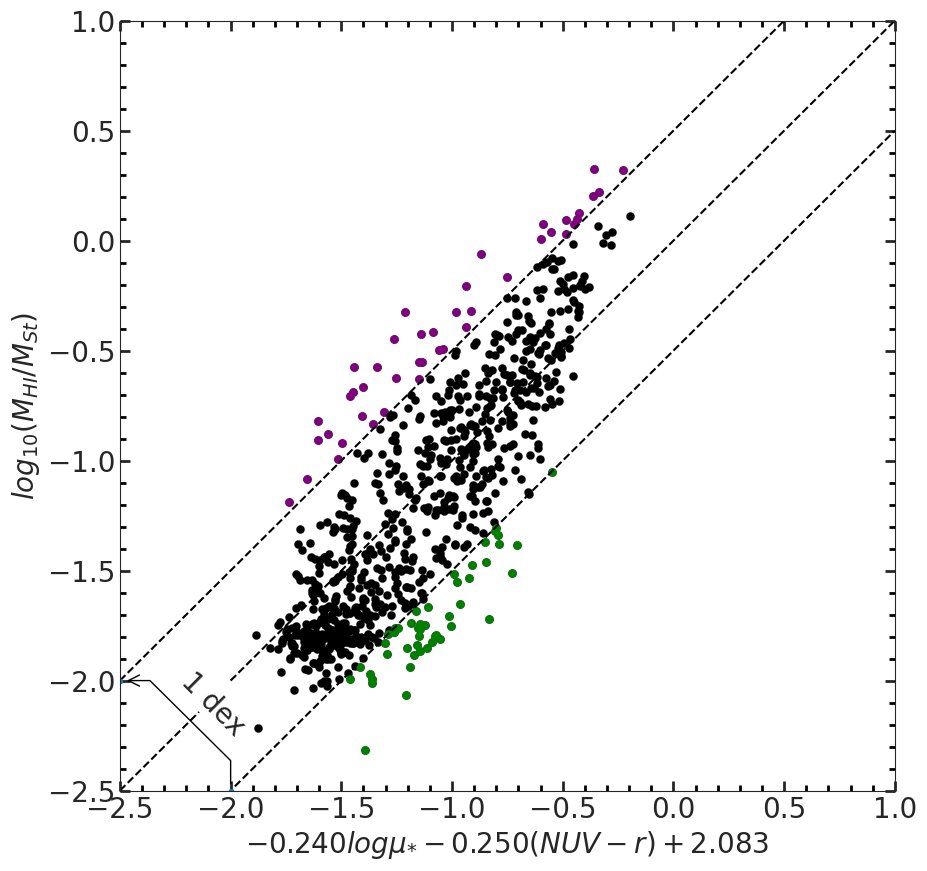

In [9]:
fig, ax  = plt.subplots(figsize = (10,10))


x = tab_rep['lgMH_Mst_pred']
y = tab_rep['lgGF']

ax.scatter(x,y,color = 'black', marker = 'o', linewidth = 0.1, label = 'Total')

x = tab_HI_def['lgMH_Mst_pred']
y = tab_HI_def['lgGF']

img = ax.scatter(x,y, color = 'green',marker = 'o', linewidth = 0.1,
                 label = 'HI Deficient')

x = tab_HI_exc['lgMH_Mst_pred']
y = tab_HI_exc['lgGF']

img = ax.scatter(x,y, color = 'purple',marker = 'o', linewidth = 0.1,
                 label = 'HI Excess')

x= np.linspace(-2.5,1)

x= np.linspace(-2.5,1)
y=x
x= np.where( (x>-2.1)&(x<-2.05),np.nan,x)

ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1)
y = x + 0.5
ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1)
y = x - 0.5
ax.plot(x,y,'--', color = 'black')
ax.set_xlabel(r'$-0.240log\mu_{*} -0.250(NUV-r) +2.083$', fontsize = 20)
ax.set_ylabel(r'$log_{10}(M_{HI}/M_{St})$', fontsize = 20)
ax.set_ylim(-2.5,1)
ax.set_xlim(-2.5,1)
demo_con_style(ax, "arc,angleA=-90,angleB=0,armA=-30,armB=30,rad=0")

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")

#fig.suptitle('HI Scaling relation using NUV-r', y = 0.92)

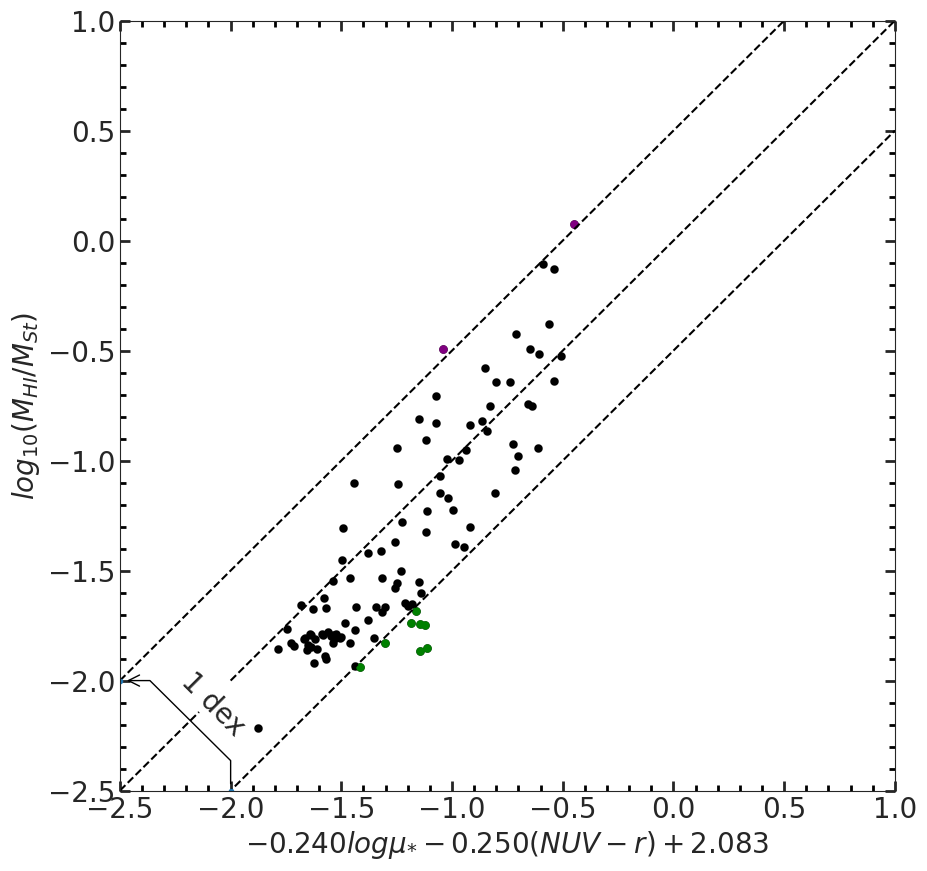

In [10]:
fig, ax  = plt.subplots(figsize = (10,10))


x = tab_rep_M['lgMH_Mst_pred']
y = tab_rep_M['lgGF']

ax.scatter(x,y,color = 'black', marker = 'o', linewidth = 0.1, label = 'Total')

x = tab_HI_def_M['lgMH_Mst_pred']
y = tab_HI_def_M['lgGF']

img = ax.scatter(x,y, color = 'green',marker = 'o', linewidth = 0.1,
                 label = 'HI Deficient')

x = tab_HI_exc_M['lgMH_Mst_pred']
y = tab_HI_exc_M['lgGF']

img = ax.scatter(x,y, color = 'purple',marker = 'o', linewidth = 0.1,
                 label = 'HI Excess')

x= np.linspace(-2.5,1)

x= np.linspace(-2.5,1)
y=x
x= np.where( (x>-2.1)&(x<-2.05),np.nan,x)

ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1)
y = x + 0.5
ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1)
y = x - 0.5
ax.plot(x,y,'--', color = 'black')
ax.set_xlabel(r'$-0.240log\mu_{*} -0.250(NUV-r) +2.083$', fontsize = 20)
ax.set_ylabel(r'$log_{10}(M_{HI}/M_{St})$', fontsize = 20)
ax.set_ylim(-2.5,1)
ax.set_xlim(-2.5,1)
demo_con_style(ax, "arc,angleA=-90,angleB=0,armA=-30,armB=30,rad=0")

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")

#fig.suptitle('HI Scaling relation using NUV-r', y = 0.92)

In [ ]:
df_noSF = df_HI_def[0:0]

for i  in df_HI_def['mangaid'].values:
    if i in idsn_:
        df_noSF = pd.concat([df_noSF,df_HI_def[df_HI_def['mangaid']==i]])

In [ ]:
df_noSF[['GASS','plateifu','mangaid', 'RA_1','Dec_1','zSDSS','NUVr', 'lgMstar','lgMHI','HI_Def','lgssfr','SFR_class']]

In [ ]:
fig, ax  = plt.subplots(figsize = (10,10))

x = tab_rep['lgMH_Mst_pred']
y = tab_rep['lgGF']

ax.scatter(x,y,color = 'black', marker = 'o', linewidth = 0.1, label = 'Total')

x = tab_HI_def['lgMH_Mst_pred']
y = tab_HI_def['lgGF']

img = ax.scatter(x,y, color = 'green',marker = 'o', linewidth = 0.1,
                 label = 'HI Deficient')

x = tab_HI_exc['lgMH_Mst_pred']
y = tab_HI_exc['lgGF']

img = ax.scatter(x,y, color = 'purple',marker = 'o', linewidth = 0.1,
                 label = 'HI Excess')

x= np.linspace(-2.5,1)

x= np.linspace(-2.5,1)
y=x
x= np.where( (x>-2.1)&(x<-2.05),np.nan,x)

ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1)
y = x + 0.5
ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1)
y = x - 0.5
ax.plot(x,y,'--', color = 'black')
ax.set_xlabel(r'$-0.240log\mu_{*} -0.250(NUV-r) +2.083$', fontsize = 20)
ax.set_ylabel(r'$log_{10}(M_{HI}/M_{St})$', fontsize = 20)
ax.set_ylim(-2.5,1)
ax.set_xlim(-2.5,1)
demo_con_style(ax, "arc,angleA=-90,angleB=0,armA=-30,armB=30,rad=0")

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")

#fig.suptitle('HI Scaling relation using NUV-r', y = 0.92)

In [ ]:
fig, ax   = plt.subplots(figsize = (10,10))

x                          = tab_rep_M['lgMH_Mst_pred']
y                          = tab_rep_M['lgGF']

cmap                       = colors.ListedColormap(['red','blue','orange','green'])

ax.scatter(x,y,color = 'black', marker = 'o', linewidth = 0.1, label = 'MaNGA')

x = df_SF['lgMH_Mst_pred']
y = df_SF['lgGF']

img = ax.scatter(x,y, color = 'blue',marker = '*', s = 100,
                 label = 'HI-Deficient Star-Forming')

x = df_noSF['lgMH_Mst_pred']
y = df_noSF['lgGF']

img = ax.scatter(x,y, color = 'red',marker = '.', s = 30,
                 label = 'HI-Deficient Quenched')

x = tab_HI_exc_M['lgMH_Mst_pred']
y = tab_HI_exc_M['lgGF']

img = ax.scatter(x,y, color = 'black',marker = 'x', s = 200 , linewidth = 3,
                 label = 'HI-Excess')

x= np.linspace(-2.5,1)

x= np.linspace(-2.5,1)
y=x
x= np.where( (x>-2.1)&(x<-2.05),np.nan,x)

ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1)
y = x + 0.5
ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1)
y = x - 0.5
ax.plot(x,y,'--', color = 'black')
ax.set_xlabel(r'$-0.240log\mu_{*} -0.250(NUV-r) +2.083$', fontsize = 20)
ax.set_ylabel(r'$Log_{10}[M_{HI}/M_{St}]$', fontsize = 20)
ax.set_ylim(-2.5,1)
ax.set_xlim(-2.5,1)
demo_con_style(ax, "arc,angleA=-90,angleB=0,armA=-30,armB=30,rad=0")

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")

#fig.suptitle('HI Scaling relation using NUV-r', y = 0.92)

### **sSFR-GSWLC**

[WARNING]: /home/avinashck/anaconda3/envs/manga/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):

[WARNING]: /home/avinashck/anaconda3/envs/manga/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):

[WARNING]: /home/avinashck/anaconda3/envs/manga/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):

[WARNING]: /home/avinashck/anaconda3/envs/manga/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

Text(8.6, -12.4, 'Quenched')

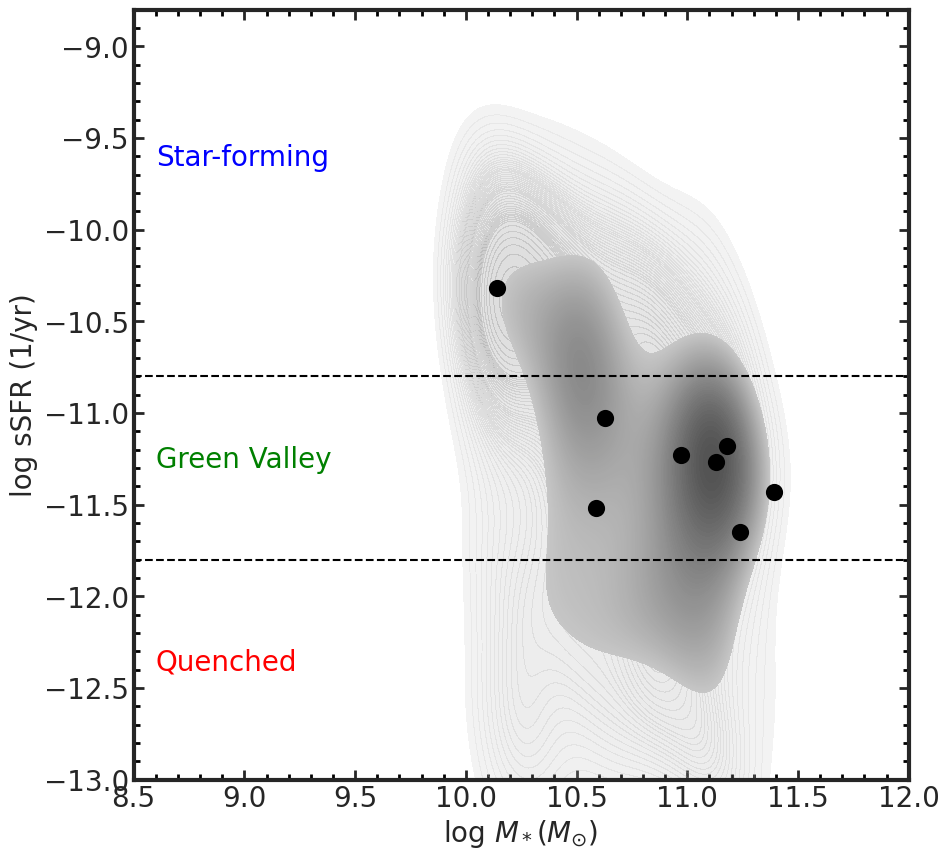

In [105]:
fig, ax  = plt.subplots()

x = tab_rep['lgM'].value
y = tab_rep['lgssfr'].value

#x = np.where(x<7,np.nan, x)

x = x.astype('float')
y = y.astype('float')
sb.kdeplot(x=x,y=y, fill = True, levels = 50, ax = ax, color = 'gray',
           legend  = True,alpha = 0.2)

x = tab_rep_M['lgM'].value
y = tab_rep_M['lgssfr'].value

x = x.astype('float')
y = y.astype('float')
sb.kdeplot(x=x,y=y, fill = True,levels = np.linspace(0.5,1,100), ax = ax,
           color ='black', alpha = 1)

x = tab_HI_def_M['lgM'].value
y = tab_HI_def_M['lgssfr'].value

#x = np.where(x<7,np.nan, x)

x = x.astype('float')
y = y.astype('float')

ax.scatter(x,y,s = 70, marker = 'o', zorder = 101, linewidths = 4, color = 'black')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")

ax.set_ylim(-13,-8.8)
ax.set_xlim(8.5,12)
ax.plot([8.5,13], [-10.8,-10.8], '--', color = 'black',label = '_nolegend_')

ax.plot([8.5,13], [-11.8,-11.8], '--', color = 'black',label = '_nolegend_')
ax.set_xlabel(r'log $M_*(M_{\odot})$', fontsize = 20)
ax.set_ylabel('log sSFR (1/yr)', fontsize = 20)


#ax.legend(['Star Forming','Quenched'])
ax.annotate('Star-forming',(8.6,-9.65), color = 'blue')
ax.annotate('Green Valley',(8.6,-11.3), color = 'green')
ax.annotate('Quenched',(8.6,-12.4), color = 'red')


[WARNING]: /home/avinashck/anaconda3/envs/manga/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):

[WARNING]: /home/avinashck/anaconda3/envs/manga/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):

[WARNING]: /home/avinashck/anaconda3/envs/manga/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):

[WARNING]: /home/avinashck/anaconda3/envs/manga/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

Text(8.6, -12.4, 'Quenched')

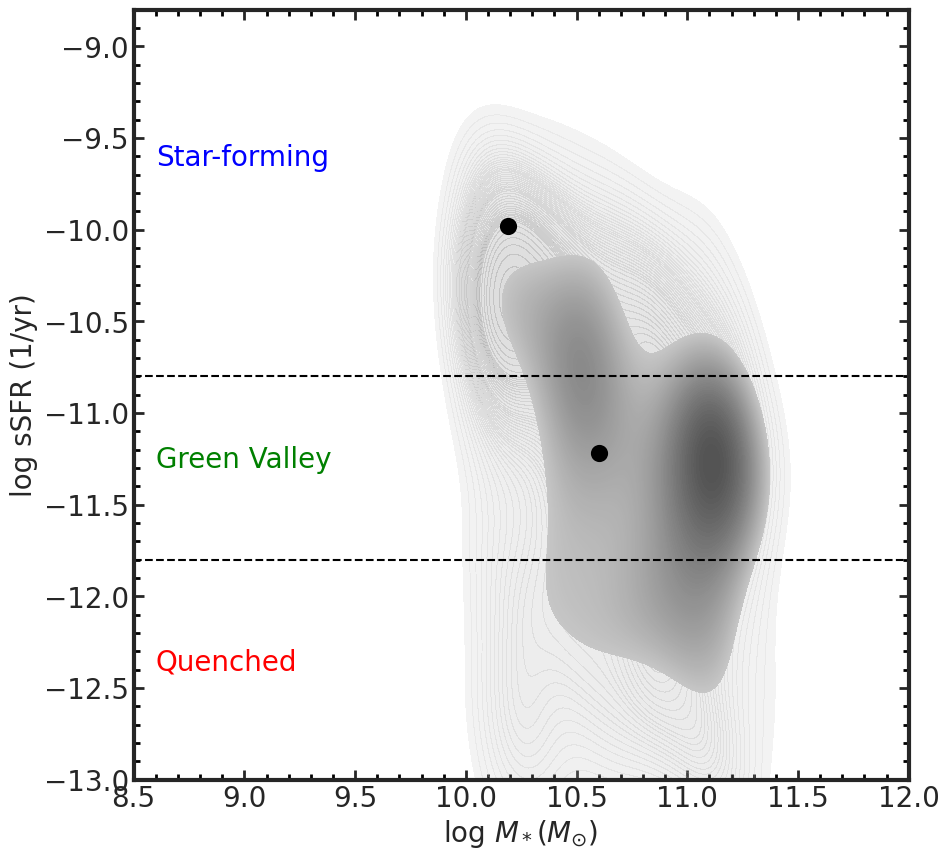

In [19]:
fig, ax  = plt.subplots()

x = tab_rep['lgM'].value
y = tab_rep['lgssfr'].value

x = np.where(x<7,np.nan, x)

x = x.astype('float')
y = y.astype('float')
sb.kdeplot(x=x,y=y, fill = True, levels = 50, ax = ax, color = 'gray',
           legend  = True,alpha = 0.2)

x = tab_rep_M['lgM'].value
y = tab_rep_M['lgssfr'].value

x = x.astype('float')
y = y.astype('float')
sb.kdeplot(x=x,y=y, fill = True,levels = np.linspace(0.5,1,100), ax = ax,
           color ='black', alpha = 1)

x = tab_HI_exc_M['lgM'].value
y = tab_HI_exc_M['lgssfr'].value

x = np.where(x<7,np.nan, x)

x = x.astype('float')
y = y.astype('float')

ax.scatter(x,y,s = 70, marker = 'o', zorder = 101, linewidths = 4, color = 'black')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")

ax.set_ylim(-13,-8.8)
ax.set_xlim(8.5,12)
ax.plot([8.5,13], [-10.8,-10.8], '--', color = 'black',label = '_nolegend_')

ax.plot([8.5,13], [-11.8,-11.8], '--', color = 'black',label = '_nolegend_')
ax.set_xlabel(r'log $M_*(M_{\odot})$', fontsize = 20)
ax.set_ylabel('log sSFR (1/yr)', fontsize = 20)


#ax.legend(['Star Forming','Quenched'])
ax.annotate('Star-forming',(8.6,-9.65), color = 'blue')
ax.annotate('Green Valley',(8.6,-11.3), color = 'green')
ax.annotate('Quenched',(8.6,-12.4), color = 'red')

### **2D Decomposition**

In [ ]:
tab_cook = Table.read('xGASS_MaNGA_cook.fits')

In [ ]:
tab_cook['mangaid'] = tab_cook['mangaid'].astype('str')

In [ ]:
tab_cook['mangaid'] = [i.split()[0] for i in tab_cook['mangaid'].value]

In [ ]:
for i in ids_:
  row = tab_cook[tab_cook['mangaid']==i]
  R_b   = row['reB_r'][0]*0.396
  M_b   = row['magB_i'][0]
  n_b   = row['nserB_i'][0]

  mu_b  = M_b + 2.5*np.log10(2*np.pi*R_b**2)
  mu_b += 2.5*np.log10(row['axratT_i'][0]) -  10*np.log10(1 + row['z'][0])

  R_b   = np.round(R_b*0.396,2)
  mu_b  = np.round(mu_b,2)
  n_b   = np.round(n_b,2)

  R_d   = row['reD_r'][0]
  M_d   = row['magD_i'][0]
  n_d   = row['nserD_i'][0]

  mu_d  = M_d + 2.5*np.log10(2*np.pi*R_d**2)
  mu_d += 2.5*np.log10(row['axratT_i'][0]) -  10*np.log10(1 + row['z'][0])

  R_d   = np.round(R_d*0.396,2)
  mu_d  = np.round(mu_d,2)
  n_d   = np.round(n_d,2)

  g_i_b  = row['magB_g'][0] - row['magB_i'][0]
  g_i_d  = row['magD_g'][0] - row['magD_i'][0]

  g_i_b   = np.round(g_i_b ,2)
  g_i_d   = np.round(g_i_d ,2)

  mangaid = row['mangaid'][0]


  print(f"{mangaid} & {mu_b} & {R_b} & {n_b} & {mu_d} & {R_d} & {n_d} & {g_i_b} & {g_i_d} \\\\")

### **Coma Galaxies**

In [ ]:
tab_coma = Table.read('Coma CC.fit')

In [ ]:
c = SkyCoord(tab_coma['RAJ2000'], tab_coma['DEJ2000'], frame='icrs', unit=(u.hourangle, u.deg))

In [ ]:
ra = []
dec = []
for pos in c:
    ra.append(pos.ra.value)
    dec.append(pos.dec.value)

In [ ]:
df_coma = tab_coma.to_pandas()

In [ ]:
df_coma['RAJ2000'] = ra
df_coma['DEJ2000'] = dec

In [ ]:
cl = []
for mangaid in tab_HI_def_M['mangaid']:
    if mangaid in ids:
        cl.append(1)
    elif mangaid in ids_:
        cl.append(0)

In [ ]:
figure, ax = plt.subplots(figsize = (10,10))
cmap = ListedColormap(['red','blue'])

ax.scatter(tab_HI_def_M['RA_1'].value, tab_HI_def_M['Dec_1'].value, c =cl,
           s = pow(10,tab_HI_def_M['HI_Def']*3.5), cmap = cmap
           ,vmin = -0.5, vmax =1.5,zorder = 100, marker = r'$\bullet$')

vr = 92/60

cen_ra = 194.953054
cen_dec = 27.980694

x_min = cen_ra  - vr - 0.2
x_max = cen_ra  + vr + 0.2
y_min = cen_dec - vr - 0.2
y_max = cen_dec + vr + 0.2

temp = tab_HI_def_M[ (tab_HI_def_M['RA_1']>x_min) & (tab_HI_def_M['RA_1']<x_max)]

temp = temp[ (temp['Dec_1']>y_min) & (temp['Dec_1']<y_max)]
for  row in temp :
    x = row['RA_1'] + 0.01
    y = row['Dec_1'] + 0.08
    text = row['mangaid']
    if text!= '1-404358' and text!= '1-456772':
        ax.annotate(text,(x,y), rotation = 25, zorder = 200, fontsize = 15)
    else:
        ax.annotate(text,(x,y-0.02), rotation = 0, zorder = 200, fontsize = 15)

ax.plot([cen_ra- vr/2,cen_ra], [cen_dec,cen_dec],'--',color = 'black', label = '_nolegend_')
ax.plot([cen_ra,cen_ra], [cen_dec +vr ,cen_dec ],'--',color = 'black', label = '_nolegend_')
sb.kdeplot(x= df_coma.RAJ2000.values, y = df_coma.DEJ2000.values, color = 'orange'
           , levels = [0.5, 0.8, 0.9,0.99, 1], label = 'Coma CC Sources',)
c = plt.Circle([cen_ra, cen_dec ], radius = vr/2,fill = False, color = 'black')
ax.add_artist(c)

c = plt.Circle([cen_ra, cen_dec], radius = vr,fill = False, color = 'black')
ax.add_artist(c)

ax.annotate(r'$0.5.r_{virial}$',(194.3, 28.05))
ax.annotate(r'$r_{virial}$',(194.8, 29), rotation = 90)

ax.set_xlim(x_min-0.2, x_max+0.2)
ax.set_ylim(y_min-0.2, y_max+0.2)
ax.set_xlabel('RA (Deg)')
ax.set_ylabel('DEC (Deg)')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())


ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")


#plt.legend(['Quenched','Star-forming'])

### **xCold GASS**

In [ ]:
tab_CO = Table.read('xCOLD_xGASS.fits')
tab_CO.rename_column('SDSS_1','SDSS')
tab_M_CO = Table.read('xCOLD_GASS_MaNGA.fits')

m = []
for i in tab_M_CO['mangaid']:
  m.append(i.split()[0])
df_M_CO = tab_M_CO.to_pandas()
df_M_CO['mangaid'] = m

df_CO_HDSF= pd.merge(df_SF,df_M_CO, on = 'mangaid')
df_CO_HDQ  = pd.merge(df_noSF, df_M_CO, on = 'mangaid')

In [ ]:
df_noSF[['mangaid','lgMHI','HIsrc']]

In [ ]:
df_CO_M_DEF = pd.merge(df_HI_def, df_M_CO, on = 'mangaid')

In [ ]:
tab_CO_GS = join(tab_rep, tab_CO, keys = 'SDSS')
tab_CO_GS_M = join(tab_rep, tab_CO, keys = 'SDSS')

In [ ]:
data = tab_CO_GS
x = data['lgMHI_1'].value.astype(float)
y = data['LOGMH2'] + data['LIM_LOGMH2']

x -= data['LOGMSTAR']
y -= data['LOGMSTAR']
y = y.value.astype(float)
z = []

for i in data['lgssfr']:
      if i<-11.8:
        z.append('Quenched')
      elif i>=-11.8 and i< -10.8:
        z.append('Green Valley')
      elif i>=-10.8:
        z.append('Star-forming')

data = data[data['HI_Def']>0.5]

cmap = ListedColormap(['red','green','blue']) #"scatter" | "kde" | "hist" | "hex" | "reg" | "resid
g = sb.jointplot(x=x,y=y,hue=z, vmin = -0.5, vmax = 2.5, kind = 'scatter' ,
                 palette = {'Quenched' : 'red', 'Green Valley' : 'green', 'Star-forming':'blue'},
                 xlim = (-2.5,1.5), ylim = (-3.5,0.5),
                 height = 10, zorder = 110, alpha = 0.8, space = 0.01, s = 0.01,
                 legend = False)
g.set_axis_labels('Log $M_{HI}/M_{St}$', r'Log $M_{H_2}/M_{St}$')

x = data['lgMHI_1'].value.astype(float)
y = data['LOGMH2'] + data['LIM_LOGMH2']

x -= data['LOGMSTAR']
y -= data['LOGMSTAR']
y = y.value.astype(float)

sb.kdeplot(x=x,y=y, fill = True ,ax = g.ax_joint, color = 'grey')
x = np.linspace(-2.5,1.5)
y = 1*x
g.ax_joint.plot(x,y, '--',color  = 'black')

x = np.linspace(-2.5,1.5)
y = 1*x - 0.5
g.ax_joint.plot(x,y,':', color  = 'black' )

x = np.linspace(-2.5,1.5)
y = 1*x - 1
g.ax_joint.plot(x,y, ':',color  = 'black')

x = np.linspace(-2.5,1.5)
y = 1*x - 1.5
g.ax_joint.plot(x,y,':', color  = 'black')


g.ax_joint.xaxis.set_minor_locator(AutoMinorLocator())
g.ax_joint.yaxis.set_minor_locator(AutoMinorLocator())


g.ax_joint.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
g.ax_joint.tick_params(which='major', length=7,direction="in")
g.ax_joint.tick_params(which='minor', length=4, color='black',direction="in")

g.ax_joint.set_yticks([-3,-2,-1,0])
g.ax_joint.set_xticks([-2,-1,0,1])
g.ax_joint.annotate('1.0',(-2.41,-2.3), rotation = 45)
g.ax_joint.annotate('0.3',(-2.2,-2.6), rotation = 45)
g.ax_joint.annotate('0.1',(-1.95,-2.85), rotation = 45)
g.ax_joint.annotate('0.03',(-1.7,-3.1), rotation = 45)


data = df_CO_HDSF
x = data['lgMHI'].values.astype(float)
y = data['LOGMH2'] + data['LIM_LOGMH2']

x -= data['LOGMSTAR']
y -= data['LOGMSTAR']
y = y.values.astype(float)

g.ax_joint.scatter(x=x,y=y, marker = '*', s= 200, color = 'blue', zorder = 200,
                    edgecolor='black', linewidth = 1)



data = df_CO_HDQ
x = data['lgMHI'].values.astype(float)
y = data['LOGMH2'] + data['LIM_LOGMH2']

x -= data['LOGMSTAR']
y -= data['LOGMSTAR']
y = y.values.astype(float)

g.ax_joint.scatter(x=x,y=y, marker = '*', s= 200, color = 'red', zorder = 200,
                   edgecolor='black', linewidth = 1)


### **SDSS Spectra**

In [ ]:
df_spec = pd.read_csv('data/HI_Def_spec.csv')
df_spec = df_spec.rename(columns = {'name' : 'mangaid'})

In [ ]:
df_spec['spec_class'] = ['Broadline', 'Star-Forming', 'Star-Forming','Broadline','Broadline',
 'Star-Forming','Broadline', 'Broadline','Star-Forming', 'Starburst',
 'Star-Forming', 'Star-Forming', 'Broadline','        ','Broadline',
 'Broadline', 'Star-Forming', 'Broadline', 'Broadline', '         ',
 'Star-Forming',  'Broadline', '        ', '         ','AGN',
  'Broadline',  'AGN', '         ' ,  'Broadline','Star-Forming',
 'Broadline', '       ', 'Broadline', '   ']

In [ ]:
cl = []
for mangaid in df_spec.mangaid:
  if mangaid in df_SF.mangaid.values:
    cl.append(1)
  else:
    cl.append(0)

In [ ]:
def SNR_cut(df,col,value):
  SNR =  df[col]/np.sqrt(df[col + '_err'])
  return np.where(SNR>=value , df[col],np.nan)

In [ ]:
df_spec['MaNGA_class'] = cl

lines = ['nii_6584_flux','h_alpha_flux','h_beta_flux','oiii_5007_flux'
          ,'oi_6300_flux','sii_6717_flux','h_alpha_eqw']
em_ab = []
for i, row in df_spec.iterrows():
  if row['h_alpha_eqw']>0:
    em_ab.append('Emission')
  else:
    em_ab.append('Absorption')

for i in lines:
  df_spec[i] = np.abs(df_spec[i].values)
  if i!= 'h_alpha_eqw':
    df_spec[i] = SNR_cut(df_spec, i,3)
df_spec['f_type'] = em_ab

In [ ]:
fig, ax = plt.subplots()

x = np.log10(df_spec['nii_6584_flux'].values/df_spec['h_alpha_flux'].values)
y = np.log10(df_spec['h_alpha_eqw'].values)

cmap = colors.ListedColormap(['red','blue'])

img = ax.scatter(x,y, c= df_spec['MaNGA_class'], cmap = cmap, vmin = -0.5, vmax =1.5)
ax.set_xlim(-1,0.6)
ax.set_ylim(-0.5, 2)
cb = plt.colorbar(img, ax = ax, label = 'MaNGA Classification')
cb.set_ticks([0,1])
cb.set_ticklabels(['Quenched','Star-Forming'])

ax.plot([-1,0.6],[np.log10(3),np.log10(3)], '--', color = 'black')
ax.plot([-1,0.6],[np.log10(0.5),np.log10(0.5)], '--', color = 'black')
ax.plot([-1,0.6],[np.log10(0.5),np.log10(0.5)], '--', color = 'black')

ax.plot([-0.4,-0.4],[np.log10(3),2], '--', color = 'black')
ax.plot([-0.4,0.6],[np.log10(6),np.log10(6)], '--', color = 'black')
"""
psf = (logniiha < -0.4) & (ewha.value > 3)                        # Pure Star Forming
  sagn = (logniiha > -0.4) & (ewha.value > 6)                       # Strong AGN
  wagn = (logniiha > -0.4) & ((ewha.value > 3) & (ewha.value < 6))  # Weak AGN
  rg = ewha.value < 3                                               # Retired Galaxy
  pg = (ewha.value < 0.5) & (ewnii.value < 0.5)                     # Passive Galaxy
"""

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               left = True, bottom = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
ax.set_title('WHAN Diagram using SDSS Spectra')
ax.set_xlabel( r'log [NII]/$H_{\alpha}$')
ax.set_ylabel(r'log $W_{H_{\alpha}}(\AA)$')

ax.annotate('SF',(-0.9,0.5))
ax.annotate('wAGN',(0.4,0.5))
ax.annotate('sAGN',(0.4,0.8))
ax.annotate('RG',(0.45,0))
ax.annotate('PG',(0.45,-0.4))

In [ ]:
whan_class = []
for i,row in df_spec.iterrows():
  x = np.log10(np.abs(row['nii_6584_flux']/row['h_alpha_flux']))
  y = np.log10(np.abs(row['h_alpha_eqw']))

  if y<= np.log10(0.5):
    whan_class.append('PG')
  elif y> np.log10(0.5) and y< np.log10(3):
    whan_class.append('RG')
  elif x<=-0.4:
    whan_class.append('SF')
  elif x>-0.4 and y<=np.log10(6):
    whan_class.append('wAGN')
  elif x>-0.4 and y>np.log10(6):
    whan_class.append('sAGN')

df_spec['WHAN_class'] = whan_class

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (20,10), sharey = True)
cmap = colors.ListedColormap(['red','blue'])

#BPT I

x = np.log10(df_spec['nii_6584_flux'].values/df_spec['h_alpha_flux'].values)
y = np.log10(df_spec['oiii_5007_flux'].values/df_spec['h_beta_flux'].values)

img = ax[0].scatter(x,y, c= df_spec['MaNGA_class'], cmap = cmap, vmin = -0.5, vmax =1.5)

bpt_class_I = []
for i,j in zip(x,y):
  if np.isnan(i)  or np.isnan(j):
    bpt_class_I.append('LowSNR')
  elif j< 0.61/(i-0.05)+1.3:
    bpt_class_I.append('SF')
  elif j >= 0.61/(i-0.05)+1.3 and j < 0.61/(i-0.47)+1.19 :
    bpt_class_I.append('Comp')
  elif j >= 0.61/(i-0.47)+1.19:
    bpt_class_I.append('AGN')

x = np.linspace(-1.3,-0.1)
y  = 0.61/(x-0.05)+1.3

ax[0].plot(x,y, '--',color = 'black')

x = np.linspace(-2, 0.3)
y  = 0.61/(x-0.47)+1.19

ax[0].plot(x,y, '-',color = 'red')

ax[0].set_xticks(np.arange(-2,0.55, 0.5))

ax[0].set_xlim(-2,1)
ax[0].set_ylim(-1.2, 1.5)

ax[0].annotate('HII',(-1,0))
ax[0].annotate('Comp',(-0.25,-0.5))
ax[0].annotate('AGN',(-0.25,1.25))

ax[0].set_xlabel( r'log [NII]/$H_{\alpha}$')
ax[0].set_ylabel(r'log OIII/$H_{\beta}$')


# BPT II

x = np.log10(df_spec['sii_6717_flux'].values/df_spec['h_alpha_flux'].values)
y = np.log10(df_spec['oiii_5007_flux'].values/df_spec['h_beta_flux'].values)

img = ax[1].scatter(x,y, c= df_spec['MaNGA_class'], cmap = cmap, vmin = -0.5, vmax =1.5)


bpt_class_II = []
for i,j in zip(x,y):
  if np.isnan(i)  or np.isnan(j):
    bpt_class_II.append('LowSNR')
  elif j< 0.72/(i-0.32) + 1.3:
    bpt_class_II.append('SF')
  elif j >= 0.72/(i-0.32) + 1.3 and j < 1.89*i + 0.76 :
    bpt_class_II.append('LINER')
  elif j >= 0.72/(i-0.32) + 1.3 and j >= 1.89*i + 0.76:
    bpt_class_II.append('Seyfert')

x = np.linspace(-2, 0.3)
y  = 0.72/(x-0.32) + 1.3

ax[1].plot(x,y, '-',color = 'red')

x = np.linspace(-0.31, 0.8)
y  = 1.89*x + 0.76
ax[1].plot(x,y, '--',color = 'Black')

ax[1].set_xlim(-1.2,0.8)

ax[1].set_xticks(np.arange(-1,0.75,0.25))

ax[1].annotate('HII',(-1,0))
ax[1].annotate('LINER',(0.25,0))
ax[1].annotate('Seyfert',(-0.5,1.25))

ax[1].set_xlabel(r'log [SII]/$H_{\beta}$')

# BPT III

x = np.log10(df_spec['oi_6300_flux'].values/df_spec['h_alpha_flux'].values)
y = np.log10(df_spec['oiii_5007_flux'].values/df_spec['h_beta_flux'].values)

img = ax[2].scatter(x,y, c= df_spec['MaNGA_class'], cmap = cmap, vmin = -0.5, vmax =1.5)

bpt_class_III = []

for i,j in zip(x,y):
  if np.isnan(i)  or np.isnan(j):
    bpt_class_III.append('LowSNR')
  elif j< 0.73/(i-0.59) + 1.33:
    bpt_class_III.append('SF')
  elif j >= 0.73/(i-0.59) + 1.33 and j < 1.18*i + 1.30 :
    bpt_class_III.append('LINER')
  elif j >= 0.73/(i-0.59) + 1.33 and j >= 1.18*i + 1.30:
    bpt_class_III.append('Seyfert')


x = np.linspace(-2, 0.3)
y  = 0.73/(x-0.59) + 1.33
ax[2].plot(x,y, '-',color = 'red')
x = np.linspace(-0.52, 0.8)
y  = 1.18*x + 1.30
ax[2].plot(x,y, '--',color = 'Black')

ax[2].set_xlim(-1.2,0.8)

ax[2].set_xticks(np.arange(-1,0.75,0.25))

ax[2].annotate('HII',(-1,0))
ax[2].annotate('LINER',(0.25,0))
ax[2].annotate('Seyfert',(-0.5,1.25))

ax[2].set_xlabel(r'log [OI]/$H_{\beta}$')

for a in ax :

  a.xaxis.set_minor_locator(AutoMinorLocator())
  a.yaxis.set_minor_locator(AutoMinorLocator())

  a.tick_params(which='both', width=2,direction="in", top = True,right = True,
                left = True, bottom = True)
  a.tick_params(which='major', length=7,direction="in")
  a.tick_params(which='minor', length=4, color='black',direction="in")


cb = plt.colorbar(img, ax = ax, label = 'MaNGA Classification', anchor = (1.3,0))
cb.set_ticks([0,1])
cb.set_ticklabels(['Quenched','Star-Forming'])
fig.suptitle('BPT Diagram with SDSS Spectra | SNR > 3')
plt.subplots_adjust(wspace = 0)

In [ ]:
x.shape

In [ ]:
bpt_class = []
for i,j,k in zip(bpt_class_I, bpt_class_II, bpt_class_III):
  if i ==j == k=='SF':
    bpt_class.append('SF')
  elif i =='Comp' and j==k =='SF':
    bpt_class.append('Comp')
  elif (i=='AGN') and (j=='LINER'  or j=='Seyfert') and (k=='LINER'  or k=='Seyfert') :
    bpt_class.append('AGN')
  elif i=='AGN' and j==k=='Seyfert':
    bpt_class.append('Seyfert')
  elif i == 'LowSNR' or j == 'LowSNR' or 'LowSNR':
    bpt_class.append('Invalid')
  else:
   bpt_class.append('Ambiguous')

In [ ]:
df_spec['BPT_class'] = bpt_class

In [ ]:
df_spec_SF = df_spec[df_spec['MaNGA_class']==1]
df_spec_noSF = df_spec[df_spec['MaNGA_class']==0]

In [ ]:
df_spec_SF[['specObjID','mangaid','spec_class','WHAN_class','BPT_class']]

In [ ]:
len(df_spec_noSF)

In [ ]:
!wget https://data.sdss.org/sas/dr17/manga/photo/pymorph/1.1.1/manga-pymorph-DR17.fits

In [ ]:
def filter_LSB(tab, hdul):

  tab['R_s']        = tab['A_HL_SE_DISK']/( 1.9992*tab['N_SE_DISK'] - 0.3271)
  tab['mu_disk_0']  = tab['M_SE_DISK'] + 2.5*np.log10(2*np.pi*tab['R_s']**2)
  tab['mu_disk_c0'] = tab['mu_disk_0'] +2.5*np.log10(tab['BA_SE_DISK']) -  10*np.log10(1 + tab['Z'])
  tab_LSB           = tab[tab['mu_disk_c0']>=21]

  tab_LSB_r = tab_LSB[['MANGA_ID'      ,'PLATEIFU'   ,'OBJID','RA','DEC'
                     ,'Z','FLAG_FAILED_S',
         'FLAG_FAILED_SE','FLAG_FIT'   ,'M_SE_BULGE','A_HL_SE_BULGE','N_SE_BULGE',
         'BA_SE_BULGE'   ,'PA_SE_BULGE','M_SE_DISK' ,'A_HL_SE_DISK' , 'R_s',
         'N_SE_DISK'     , 'BA_SE_DISK','PA_SE_DISK',
         'mu_disk_c0']].to_pandas()

  tab_g        = Table.read(hdul[1])
  tab_g['R_s'] = tab_g['A_HL_SE_DISK']/( 1.9992*tab_g['N_SE_DISK'] - 0.3271)
  tab_g['mu_disk_0'] = tab_g['M_SE_DISK'] + 2.5*np.log10(2*np.pi*tab_g['R_s']**2)
  tab_g['mu_disk_c0']  = tab_g['mu_disk_0'] +2.5*np.log10(tab_g['BA_SE_DISK']) -  10*np.log10(1 + tab_g['Z'])

  tab_g = tab_g[['MANGA_ID'      ,'PLATEIFU'   ,'OBJID','RA','DEC'          ,'Z','FLAG_FAILED_S',
          'FLAG_FAILED_SE','FLAG_FIT'   ,'M_SE_BULGE','A_HL_SE_BULGE','N_SE_BULGE',
          'BA_SE_BULGE'   ,'PA_SE_BULGE','M_SE_DISK' ,'A_HL_SE_DISK' , 'R_s',
          'N_SE_DISK'     , 'BA_SE_DISK','PA_SE_DISK',
          'mu_disk_c0']].to_pandas()

  tab_LSB_g = tab_LSB_r[0:0]
  for i in tab_LSB_r['MANGA_ID']:
    if i in tab_LSB_r['MANGA_ID'].values:
      tab_LSB_g = tab_LSB_g.append(tab_g[tab_g['MANGA_ID']==i])

  tab_i        = Table.read(hdul[3])
  tab_i['R_s'] = tab_i['A_HL_SE_DISK']/( 1.9992*tab_i['N_SE_DISK'] - 0.3271)
  tab_i['mu_disk_0'] = tab_i['M_SE_DISK'] + 2.5*np.log10(2*np.pi*tab_i['R_s']**2)
  tab_i['mu_disk_c0']  = tab_i['mu_disk_0'] +2.5*np.log10(tab_i['BA_SE_DISK']) -  10*np.log10(1 + tab_i['Z'])

  tab_i = tab_i[['MANGA_ID'      ,'PLATEIFU'   ,'OBJID','RA','DEC'          ,'Z','FLAG_FAILED_S',
          'FLAG_FAILED_SE','FLAG_FIT'   ,'M_SE_BULGE','A_HL_SE_BULGE','N_SE_BULGE',
          'BA_SE_BULGE'   ,'PA_SE_BULGE','M_SE_DISK' ,'A_HL_SE_DISK' , 'R_s',
          'N_SE_DISK'     , 'BA_SE_DISK','PA_SE_DISK',
          'mu_disk_c0']].to_pandas()

  tab_LSB_i = tab_LSB_r[0:0]
  for i in tab_LSB_r['MANGA_ID']:
    if i in tab_LSB_r['MANGA_ID'].values:
      tab_LSB_i = tab_LSB_i.append(tab_g[tab_g['MANGA_ID']==i])
  return tab_LSB_g, tab_LSB_r, tab_LSB_i

In [ ]:
hdul = fits.open('manga-pymorph-DR17.fits')
tab    = Table.read(hdul[2])
tab_pym    = Table.read(hdul[2])

In [ ]:
tab_SE = tab[tab['A_HL_SE_BULGE']<tab['A_HL_SE_DISK']]
tab_SE = tab_SE[tab_SE['FLAG_FIT']==2]

LSB_g1, LSB_r1, LSB_i1 = filter_LSB(tab_SE,hdul)

In [ ]:
len(LSB_r1)

In [ ]:
tab_SE = tab[tab['A_HL_SE_BULGE']>tab['A_HL_SE_DISK']]
tab_SE = tab_SE[tab_SE['FLAG_FIT']==2]
tab_SE['N_SE_DISK'] = tab_SE['N_SE_BULGE']
tab_SE['A_HL_SE_DISK'] = tab_SE['A_HL_SE_BULGE']
tab_SE['M_SE_DISK'] = tab_SE['M_SE_BULGE']
tab_SE['BA_SE_DISK'] = tab_SE['BA_SE_BULGE']

LSB_g2, LSB_r2, LSB_i2 = filter_LSB(tab_SE,hdul)

In [ ]:
len(LSB_r2)

In [ ]:
tab_SE = tab[tab['A_HL_SE_BULGE']<tab['A_HL_SE_DISK']]
tab_SE = tab_SE[tab_SE['FLAG_FIT']==1]
tab_SE = tab_SE[tab_SE['FLAG_FIT']==1]

tab_SE['N_SE_DISK']    = tab_SE['N_S']
tab_SE['A_HL_SE_DISK'] = tab_SE['A_HL_S']
tab_SE['M_SE_DISK']    = tab_SE['M_S']
tab_SE['BA_SE_DISK']   = tab_SE['BA_S']

LSB_g3, LSB_r3, LSB_i3 = filter_LSB(tab_SE,hdul)
len(LSB_r3)

In [ ]:
len(LSB_r1) + len(LSB_r2) + len(LSB_r3)

In [ ]:
LSB_r1.to_csv('LSB_r_SE_sersicbulge.csv')
LSB_r2.to_csv('LSB_r_SE_expbulge.csv')

LSB_r3.to_csv('LSB_r_S.csv')

In [ ]:
for i in df_HI_def.mangaid:
  if i in LSB_r1.MANGA_ID.values:
    print(i)
  if i in LSB_r2.MANGA_ID.values:
    print(i)
  if i in LSB_r3.MANGA_ID.values:
    print(i)

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

In [ ]:
cd '/content/gdrive/MyDrive/Star forming Bars in S0 Galaxies/DR17/S0/SFB'

In [ ]:
ls

Choose a location in your drive

In [ ]:
cd '/content/gdrive/MyDrive/'

In [ ]:
ids = [i[:-9] for i in os.listdir()]
ids

In [ ]:
download = 0
format   = 'png'

for plateifu in df_SF.plateifu:

  if not os.path.exists(f'{plateifu}'):
      os.mkdir(f'{plateifu}')

  maps = Maps(plateifu=plateifu,mode='remote')
  mangaid = maps.mangaid

  # Set the size of image cutout
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()
  scale_s = optical.wcs.to_header()['PC2_2']*3600
  size_s  = 2*optical.wcs.to_header()['CRPIX1']*scale_s

  # Physical Scale
  c          = 299792  # speed of light [km/s]
  H0         = 70  # [km s^-1 Mpc^-1]
  redshift   = maps.dapall['z']
  D          = c * redshift / H0  # approx. distance to galaxy [Mpc]
  dist_scale = 1 / 206265 * D * 1e3  # kpc per arc_secs
  d          = size_s*dist_scale
  r          = d/2  #kpc.

  # Optical Image
  fig = plt.figure(figsize = (10,10))
  ax1 = fig.add_subplot()
  ax1.grid(False)
  ax1.imshow(optical.data, extent = (-r,r,-r,r))
  ax1.grid(False)

  if download:
      fig.savefig(f'{plateifu}/SDSS_cutout',bbox_inches = 'tight',format=format)

  #------------------------------------------------------------------------------------------

  # Get DeCALS Image
  scale_s = optical.wcs.to_header()['PC2_2']*3600
  size_s  = 2*optical.wcs.to_header()['CRPIX1']*scale_s
  img = Cutout_L(ra = optical.ra, dec = optical.dec, width = size_s, height=size_s, scale = size_s/512 )

  fig = plt.figure(figsize = (10,10))
  ax1 = fig.add_subplot()
  ax1.grid(False)
  ax1.imshow(img.image, extent = (-r,r,-r,r))
  ax1.grid(False)
  #ax1.annotate(f'manga {plateifu}',(512-512/3,512-512/20),weight='bold',family='serif',color = 'white')
  if download:
      fig.savefig(f'{plateifu}/legacy_cutout',bbox_inches = 'tight',format=format)

    # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]

# H-alpha with optical contours

  fig = plt.figure(figsize = (10,10))
  ax3 = fig.add_subplot( )
  ha = maps.emline_gflux_ha_6564

  d = size*dist_scale
  r = d/2

  ax3.grid(False)
  cbr = mapplot.plot(dapmap=ha,return_cbrange=True)
  img = ax3.imshow(goodspax(ha),vmin=cbr[0],vmax=cbr[1],cmap='jet', extent = (-r,r,-r,r), origin = 'lower')
  ax3.grid(False)
  #ax3.set_autoscale_on(False)
  #ax3.contour(filter_r, transform=ax3.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  #ax3.annotate(r'H alpha Map',(len(ha)-len(ha)/3.5,len(ha)-len(ha)/13),weight='bold',family='serif')
  cb=plt.colorbar(img,ax=ax3,anchor=(0,5),shrink=0.824)
  cb.set_label(r'$1\times10^{-17}ergcm^{-2}s^{-1}$')

  if download:
      fig.savefig(f'{plateifu}/H_alpha',bbox_inches = 'tight',format = format)
  #------------------------------------------------------------------------------------------

  # H-delta with optical contours

  fig = plt.figure(figsize = (10,10))
  ax3 = fig.add_subplot( projection=maps.wcs,slices=('x','y',0))
  ha = maps.emline_gflux_hdel_4102

  ax3.grid(False)
  cbr = mapplot.plot(dapmap=ha,return_cbrange=True)
  img = ax3.imshow(goodspax(ha),vmin=cbr[0],vmax=cbr[1],cmap='jet')
  ax3.grid(False)
  ax3.set_autoscale_on(False)
  ax3.contour(filter_r, transform=ax3.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  #ax3.annotate(r'H delta Map',(len(ha)-len(ha)/3.5,len(ha)-len(ha)/13),weight='bold',family='serif')
  cb=plt.colorbar(img,ax=ax3,anchor=(0,5),shrink=0.824)
  cb.set_label(r'$1\times10^{-17}ergcm^{-2}s^{-1}$')
  ax3.set_xlabel('pos.eq.ra')
  ax3.set_ylabel('pos.eq.dec')
  ax3.axis('off')

  if download:
      fig.savefig(f'{plateifu}/H_delta',bbox_inches = 'tight',format = format)
  #------------------------------------------------------------------------------------------

  # WHAN Map

  # grab the NII/Ha flux ratio, Ha and NII equivalent width arrays
  nii=maps.emli40ne_gflux_nii_6585
  ha=maps.emline_gflux_ha_6564
  niiha = nii/ha
  ewha = maps['emline_sew_ha_6564']
  ewnii = maps['emline_sew_nii_6585']
  # take the log of the NII/Ha ratio
  logniiha = np.log10(niiha.value)

  # create the WHAN categories
  psf  = (logniiha < -0.4)  & (ewha.value > 3)
  sagn = (logniiha > -0.4)  & (ewha.value > 6)
  wagn = (logniiha > -0.4)  & ((ewha.value > 3) & (ewha.value < 6))
  rg   = ewha.value < 3
  pg   = (ewha.value < 0.5) & (ewnii.value < 0.5)

  # create a custom array for a WHAN categories (we copy the EW Ha array just to get a 2d-array of the original size)
  value = ewha.value.copy()
  value[psf]  = 1     # pure star-forming
  value[sagn] = 2     # strong agn
  value[wagn] = 3     # weak agn
  value[rg]   = 4     # retired galaxies
  value[pg]   = 5     # passive galaxies

  # Set ivar to 0 where the SNR < 1
  niiha_low_snr = mapplot.mask_low_snr(niiha.value, niiha.ivar, snr_min=1)
  ewha_low_snr = mapplot.mask_low_snr(ewha.value, ewha.ivar, snr_min=1)
  ewnii_low_snr = mapplot.mask_low_snr(ewnii.value, ewnii.ivar, snr_min=1)
  low_snr = np.logical_or(niiha_low_snr, ewha_low_snr, ewnii_low_snr)

  ivar = ewha.value.copy()
  ivar[low_snr] = 0
  value[low_snr] = np.nan

  # Set the size of image cutout
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # WHAN IFU
  fig = plt.figure(figsize = (10,10))
  ax2 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
  ax2.grid(False)
  cmap = colors.ListedColormap(['red', 'blue', 'goldenrod', 'green', 'purple'])
  nocov = ewha.pixmask.get_mask('NOCOV',dtype=np.bool)
  mask = np.where(nocov==True,np.nan,1)
  #fig, ax2, cb = mapplot.plot(value=value, ivar=ivar, mask=nocov, cmap=cmap,fig=fig,ax=ax2, use_masks='NOCOV', return_cb=True, cbrange=(0.5, 5.5), title='')
  img = ax2.imshow(value,cmap=cmap,vmin=0.5,vmax=5.5)
  ax2.grid(False)
  ax2.set_autoscale_on(False)
  #ax2.annotate(r'WHAN Map',(len(ha)-len(ha)/4,len(ha)-len(ha)/13),weight='bold',family='serif')

  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]
  ax2.contour(filter_r, transform=ax2.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)

  cb=plt.colorbar(img,ax=ax2,anchor=(0,5),shrink=0.824)
  cb.set_ticks([1, 2, 3, 4, 5])
  cb.set_ticklabels(['PSF', 'SAGN', 'WAGN', 'RG', 'PG'])
  ax2.set_xlabel('pos.eq.ra')
  ax2.set_ylabel('pos.eq.dec')
  ax2.axis('off')
  if download:
      fig.savefig(f'{plateifu}/WHAN',bbox_inches = 'tight',format=format)
  #------------------------------------------------------------------------------------------

  fig = plt.figure(figsize = (10,10))
  ax4 = fig.add_subplot()
  m, f ,a = maps.get_bpt(show_plot=False)

  SF = sf= m['sf']['global'].astype('float64')*5
  COMP = m['comp']['global'].astype('float64')*4
  LIN = m['liner']['global'].astype('float64')*3
  SEY = m['seyfert']['global'].astype('float64')*2
  AMB = m['ambiguous']['global'].astype('float64')*1

  bpt = SF + COMP + LIN + SEY + AMB

  cmap = colors.ListedColormap(['grey','red', 'purple', 'green', 'cyan'])
  nocov = ewha.pixmask.get_mask('NOCOV')

  bpt[bpt==0]=np.nan

  #fig, ax4, cb = mapplot.plot(value=bpt, ivar = bpt, mask=nocov, cmap=cmap,fig=fig,ax=ax4, use_masks='NOCOV', return_cb=True, cbrange=(0.5, 5.5), title='')
  img = ax4.imshow(bpt,cmap=cmap,vmin=0.5,vmax=5.5,extent = (-r,r,-r,r), origin = 'lower')
  #ax4.set_autoscale_on(False)
  #ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)

  cb=plt.colorbar(img,ax=ax4,anchor=(0,5),shrink=0.824)
  cb.set_ticks([1, 2, 3, 4, 5])
  cb.set_ticklabels(['Ambiguous','Seyfert','LINER','Comp', 'SF'])

  #ax4.annotate(r'BPT Map',(len(ha)-len(ha)/4.6,len(ha)-len(ha)/12),weight='bold',family='serif')

  if download:
      fig.savefig(f'{plateifu}/BPT',bbox_inches = 'tight', format = format)

  #------------------------------------------------------------------------------------------

  dn=maps.specindex_dn4000

  fig = plt.figure(figsize = (10,10))
  ax4 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
  ax4.grid(False)
  cbr=mapplot.plot(dapmap=dn,return_cbrange=True)
  img = ax4.imshow(goodspax(dn),vmin=cbr[0],vmax=cbr[1],cmap='jet')
  ax4.grid(False)
  ax4.set_autoscale_on(False)
  ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  cb=plt.colorbar(img,ax=ax4,anchor=(0,5),shrink=0.824)
  ax4.set_xlabel('pos.eq.ra')
  ax4.set_ylabel('pos.eq.dec')
  #ax4.annotate(r'Dn 4000 Map',(len(ha)-len(ha)/3.3,len(ha)-len(ha)/13),weight='bold',family='serif')

  ax4.axis('off')
  if download:
      fig.savefig(f'{plateifu}/DN4000',bbox_inches = 'tight',format = format)

  #------------------------------------------------------------------------------------------
  fig = plt.figure(figsize = (10,10))
  ax3 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
  nii = maps.emline_gflux_nii_6585
  n2 = nii/ ha
  logn2 = np.log10(n2)
  logoh = 8.90 + 0.57 * logn2

  mask_bad_data = n2.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
  min_snr = 3.
  mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
  mask_ha_low_snr = (np.abs(ha.value * np.sqrt(ha.ivar)) < min_snr)

  mask =  (mask_bad_data | mask_nii_low_snr | mask_ha_low_snr).astype(np.bool)
  ax3.grid(False)
  cbr = mapplot.plot(dapmap=logoh,mask=mask,return_cbrange=True)
  mask = np.where(mask==True,np.nan,1)
  img = ax3.imshow(logoh.value*mask,vmin=cbr[0],vmax=cbr[1],cmap = 'viridis')
  ax3.grid(False)
  ax3.set_autoscale_on(False)
  ax3.contour(filter_r, transform=ax3.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  cb=plt.colorbar(img,ax=ax3,anchor=(0,5),shrink=0.824,label= '12+log(O/H)')
  ax3.set_xlabel('pos.eq.ra')
  ax3.set_ylabel('pos.eq.dec')
  #ax3.annotate(r'N2 Metallicity Map',(len(ha)-len(ha)/2.5,len(ha)-len(ha)/13),weight='bold',family='serif')
  ax3.axis('off')
  if download:
      fig.savefig(f'{plateifu}/Metallicity',bbox_inches = 'tight',format = format)

  #------------------------------------------------------------------------------------------

  hb = maps.emline_gflux_hb_4862
  ha_hb = maps.getMapRatio('emline_gflux','ha_6564','hb_4862')
  ha_sf    = ha*sf
  hb_sf    = hb*sf
  ha_hb_sf = ha_hb*sf

  z = maps.dapall['z']

  fa = ha_sf*1e-17*pow(10,2.468*0.934*np.log10(ha_hb_sf.value/2.86))
  D_L = cosmo.luminosity_distance(z).to(u.cm)
  Lha =  (fa.value*4*np.pi*D_L*D_L)*(u.erg/u.second)
  SFR = 5.5e-42*Lha
  SFR = SFR.value*(u.solMass/u.year)
  cube = maps.getCube()

  M    = cube.vacs.firefly['mastar']

  M = cube.vacs.firefly['mastar']._make_map('stellar_mass')
  M = 10**np.where(M>-10,M,0)

  sSFR = np.log10(SFR.value/M)

  fig = plt.figure(figsize = (10,10))
  ax4 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
  ax4.grid(False)

  ax4.imshow(sSFR, cmap = 'jet')
  ax4.grid(False)
  ax4.set_autoscale_on(False)
  ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  if download:
    fig.savefig(f'{plateifu}/sSFR',bbox_inches = 'tight',format = format)

  ang_dist = Planck15.kpc_proper_per_arcmin(z).to(u.kpc/u.arcsec)
  area = (ang_dist.value**2*maps.bin_area.value)
  area = area*(u.kpc**2)
  SFRD = SFR/area

  R   = maps.spx_ellcoo_elliptical_radius.value
  R_e = float(maps.header['reff'])

  x = (R/R_e)
  y = SFRD

  fig = plt.figure(figsize = (10,10))
  ax = fig.add_subplot()
  ax.scatter(x,y)
  ax.set_xlabel(r'$R/R_e$')
  ax.set_ylabel('SFRD ' + r'$M_{\odot}kpc^{-2}yr^{-1}$')

  ax.xaxis.set_minor_locator(AutoMinorLocator())
  ax.yaxis.set_minor_locator(AutoMinorLocator())

  ax.tick_params(which='both', width=2,direction="in")
  ax.tick_params(which='major', length=7,direction="in")
  ax.tick_params(which='minor', length=4, color='black',direction="in")

  if download:
      fig.savefig(f'{plateifu}/SFRD',bbox_inches = 'tight',format = format)

  #------------------------------------------------------------------------------------------

  # OIII/OII map
  OIII_OII= maps.getMapRatio('emline_gflux','oiii_5008','oii_3729')

  fig = plt.figure(figsize = (10,10))
  ax4 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
  ax4.grid(False)
  cbr = mapplot.plot(dapmap = OIII_OII, return_cbrange = True)

  img = ax4.imshow(goodspax(OIII_OII),vmin=cbr[0],vmax=cbr[1],cmap = 'magma')
  ax4.grid(False)
  ax4.set_autoscale_on(False)
  ax4.contour(filter_r, transform = ax4.get_transform(optical.wcs), colors = 'red',levels = levels,zorder=11)
  cb=plt.colorbar(img, ax=ax4,anchor=(0,5),shrink=0.824)
  ax4.set_xlabel('pos.eq.ra')
  ax4.set_ylabel('pos.eq.dec')
  #ax4.annotate(r'OIII/OII Map',(len(ha)-len(ha)/3.3,len(ha)-len(ha)/13),weight='bold',family='serif')
  ax4.axis('off')
  if download:
      fig.savefig(f'{plateifu}/OIII_OII',bbox_inches = 'tight',format = format)

  #------------------------------------------------------------------------------------------

    # H alpha EW
  ewha = maps['emline_sew_ha_6564']
  fig = plt.figure(figsize = (10,10))
  ax2 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))

  ax2.grid(False)
  cbr=mapplot.plot(dapmap=ewha,return_cbrange=True)
  img = ax2.imshow(goodspax(ewha),vmin=cbr[0],vmax=cbr[1],cmap = 'plasma')
  ax2.grid(False)
  ax2.set_autoscale_on(False)
  ax2.contour(filter_r, transform=ax2.get_transform(optical.wcs), colors='white',levels=levels,zorder=11)
  cb=plt.colorbar(img,ax=ax2,anchor=(0,5),shrink=0.824)
  ax2.set_xlabel('pos.eq.ra')
  ax2.set_ylabel('pos.eq.dec')
  #ax2.annotate(r'H alpha EW Map',(len(ha)-len(ha)/2.7,len(ha)-len(ha)/13),weight='bold',family='serif')
  cb.set_label(r'$\AA$')
  ax2.axis('off')
  if download:
      fig.savefig(f'{plateifu}/ewH_alpha',bbox_inches = 'tight')

  #--------------------------------------------------------------------------------------------
    # H delta EW
  ewha = maps.emline_sew_hdel_4102
  fig = plt.figure(figsize = (10,10))
  ax2 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))

  ax2.grid(False)
  cbr=mapplot.plot(dapmap=ewha,return_cbrange=True)
  img = ax2.imshow(goodspax(ewha),vmin=cbr[0],vmax=cbr[1],cmap = 'plasma')
  ax2.grid(False)
  ax2.set_autoscale_on(False)
  ax2.contour(filter_r, transform=ax2.get_transform(optical.wcs), colors='white',levels=levels,zorder=11)
  cb=plt.colorbar(img,ax=ax2,anchor=(0,5),shrink=0.824)
  ax2.set_xlabel('pos.eq.ra')
  ax2.set_ylabel('pos.eq.dec')
  #ax2.annotate(r'H delta EW Map',(len(ha)-len(ha)/2.7,len(ha)-len(ha)/13),weight='bold',family='serif')
  cb.set_label(r'$\AA$')

  ax2.axis('off')
  if download:
      fig.savefig(f'{plateifu}/ewH_delta',bbox_inches = 'tight')

  # OIII 5007 EW
  ewOIII = maps['emline_sew_oiii_5008']
  fig = plt.figure(figsize = (10,10))
  ax3 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))

  ax3.grid(False)
  cbr = mapplot.plot(dapmap = ewOIII ,return_cbrange = True)
  img = ax3.imshow(goodspax(ewOIII),vmin=cbr[0],vmax=cbr[1],cmap = 'plasma')
  ax3.grid(False)
  ax3.set_autoscale_on(False)
  ax3.contour(filter_r, transform = ax3.get_transform(optical.wcs), colors = 'white',levels = levels,zorder=11)
  cb=plt.colorbar(img,ax=ax3,anchor=(0,5),shrink=0.824)
  ax3.set_xlabel('pos.eq.ra')
  ax3.set_ylabel('pos.eq.dec')
  ax3.annotate(r'OIII EW Map',(len(ha)-len(ha)/3.3,len(ha)-len(ha)/13),weight='bold',family='serif')
  cb.set_label(r'$\AA$')

  ax3.axis('off')
  if download:
      fig.savefig(f'{plateifu}/ewOIII',bbox_inches = 'tight',format = format)
    #------------------------------------------------------------------------------------------
  break

In [ ]:
r

In [ ]:
# Set the size of image cutout
scale = maps.wcs.to_header()['PC2_2']*3600
size = 2*maps.wcs.to_header()['CRPIX1']*scale

# Get SDSS Image
optical=maps.getImage()
scale_s = optical.wcs.to_header()['PC2_2']*3600
size_s  = 2*optical.wcs.to_header()['CRPIX1']*scale_s

# GalFIT apertures
with open(f'/content/Kugelblitz/data/{plateifu}.json', 'r') as fout:
  m = json.load(fout)

mods = m[0]

# Physical Scale
c          = 299792  # speed of light [km/s]
H0         = 70  # [km s^-1 Mpc^-1]
redshift   = maps.dapall['z']
D          = c * redshift / H0  # approx. distance to galaxy [Mpc]
dist_scale = 1 / 206265 * D * 1e3  # kpc per arc_secs
d          = size_s*dist_scale
r          = d/2  #kpc.

# Optical Image
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot()
ax1.grid(False)
ax1.imshow(optical.data, extent = (-r,r,-r,r))
ax1.grid(False)

apertures = aperture_gen(mods[:-1],dist_scale,r,
                        origin = 'center', a_offset = 45)

for k, aperture in enumerate(apertures):
  apertures[aperture].plot(ax1,color = colors_[k], label = models[k])
ax1.legend()
ax1.set_xlabel('kpc')
ax1.set_ylabel('kpc')

In [ ]:
download = 0
format   = 'png'
for plateifu in dr16:

  if not os.path.exists(f'{plateifu}'):
      os.mkdir(f'{plateifu}')

  maps = Maps(plateifu=plateifu,mode='remote')
  mangaid = maps.mangaid

  # Set the size of image cutout
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r = np.rot90(np.array(optical.data)[:,:,0].T )
  levels   = [60.,  90., 120., 150., 180., 210., 240.]
  ha       = maps.emline_gflux_ha_6564
  hb       = maps.emline_gflux_hb_4862
  ha_hb    = maps.getMapRatio('emline_gflux','ha_6564','hb_4862')

  m, f ,a  = maps.get_bpt(show_plot=False)

  sf       = m['sf']['global'].astype('float64')
  ha_sf    = ha*sf
  hb_sf    = hb*sf
  ha_hb_sf = ha_hb*sf

  z = maps.dapall['z']

  fa   = ha_sf*1e-17*pow(10,2.468*0.934*np.log10(ha_hb_sf.value/2.86))
  D_L  = cosmo.luminosity_distance(z).to(u.cm)
  Lha  =  (fa.value*4*np.pi*D_L*D_L)*(u.erg/u.second)
  SFR  = 5.5e-42*Lha
  SFR  = SFR.value*(u.solMass/u.year)
  cube = maps.getCube()

  M    = cube.vacs.firefly['mastar']

  M = cube.vacs.firefly['mastar']._make_map('stellar_mass')
  M = 10**np.where(M>-10,M,0)

  sSFR = np.log10(SFR.value/M)

  fig = plt.figure(figsize = (10,10))
  ax4 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
  ax4.grid(False)

  img = ax4.imshow(sSFR, cmap = 'jet')
  ax4.grid(False)
  ax4.set_autoscale_on(False)
  ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  cb = plt.colorbar(img, ax = ax4, shrink = 0.8)
  cb.set_label(r'$Log_{10}(1/yr)$')

  ax4.annotate(r'sSFR Map',(len(ha)-len(ha)/3.3,len(ha)-len(ha)/13),weight='bold',family='serif')
  if download:
    fig.savefig(f'{plateifu}/sSFR',bbox_inches = 'tight',format = format)

In [ ]:
cube.vacs.firefly['mastar'].data

In [ ]:
fig  = plt.figure(figsize = (33,60))
spec = gridspec.GridSpec(ncols=4, nrows=8, width_ratios=[1,1, 1.32,1.24], wspace=0.01,hspace=0.01)
for i,fil in enumerate(os.listdir()):

  img = plt.imread(f'{fil}/legacy_cutout')
  ax = fig.add_subplot(spec[i,0])
  ax.imshow(img)
  ax.axis('off')

  img = plt.imread(f'{fil}/SDSS_cutout')
  ax = fig.add_subplot(spec[i,1])
  ax.imshow(img)
  ax.axis('off')

  img = plt.imread(f'{fil}/BPT')
  ax = fig.add_subplot(spec[i,2])
  ax.imshow(img)
  ax.axis('off')

  img = plt.imread(f'{fil}/H_alpha')
  ax = fig.add_subplot(spec[i,3])
  ax.imshow(img)
  ax.axis('off')

In [ ]:
fig  = plt.figure(figsize = (35,60))
spec = gridspec.GridSpec(ncols=4, nrows=8, width_ratios=[1,1.001, 0.97,1.], wspace=0.01,hspace=0.01)
for i,fil in enumerate(os.listdir()[3:-1]):

  img = plt.imread(f'{fil}/ewH_alpha.png')
  ax = fig.add_subplot(spec[i,0])
  ax.imshow(img)
  ax.axis('off')

  img = plt.imread(f'{fil}/H_delta')
  ax = fig.add_subplot(spec[i,1])
  ax.imshow(img)
  ax.axis('off')

  img = plt.imread(f'{fil}/DN4000')
  ax = fig.add_subplot(spec[i,2])
  ax.imshow(img)
  ax.axis('off')

  img = plt.imread(f'{fil}/Metallicity')
  ax = fig.add_subplot(spec[i,3])
  ax.imshow(img)
  ax.axis('off')

# **HI-MaNGA**

## **PIPE 3D**

In [7]:
tab_HI = Table.read('../data/HI_MaNGA_PIPE3D_Baldry.fits')

In [8]:
tab_HI['sSFR'] = tab_HI['log_SFR_SF'] - tab_HI['log_Mass']

In [9]:
df_HI = tab_HI[(tab_HI['conflag']==0) & (tab_HI['LOGMSTARS']>0)]

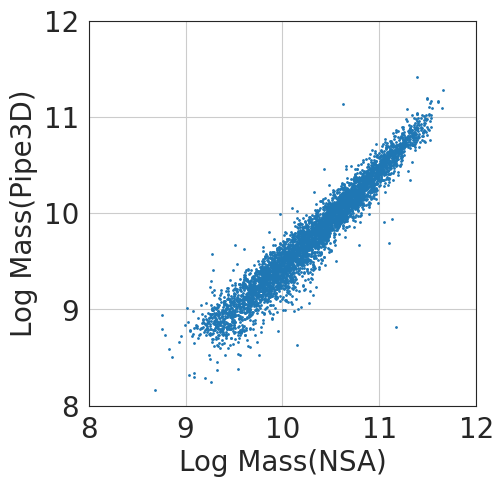

In [19]:
x = df_HI['log_Mass']
y = df_HI['LOGMSTARS']
plt.figure(figsize=(5,5))
plt.scatter(x,y, s=1)
plt.grid()
plt.xlim(8,12)
plt.ylim(8,12)

plt.xlabel('Log Mass(NSA)')
plt.ylabel('Log Mass(Pipe3D)')
plt.show()

In [41]:
df_HI =  df_HI[df_HI['density']<-0.5]
df_HI_d = df_HI[df_HI['LOGMHI']>0]
df_HI_nd = df_HI[ df_HI['LOGHILIM200KMS']>0]

In [42]:
df_HI_d['MHI_MST'] = df_HI_d['LOGMHI'] - df_HI_d['LOGMSTARS']
df_HI_nd['MHI_MST'] = df_HI_nd['LOGHILIM200KMS'] - df_HI_nd['LOGMSTARS']

In [43]:
df_HI_dQ = df_HI_d[df_HI_d['sSFR']<-11.8]
df_HI_ndSF = df_HI_nd[df_HI_nd['sSFR']>-10.8]

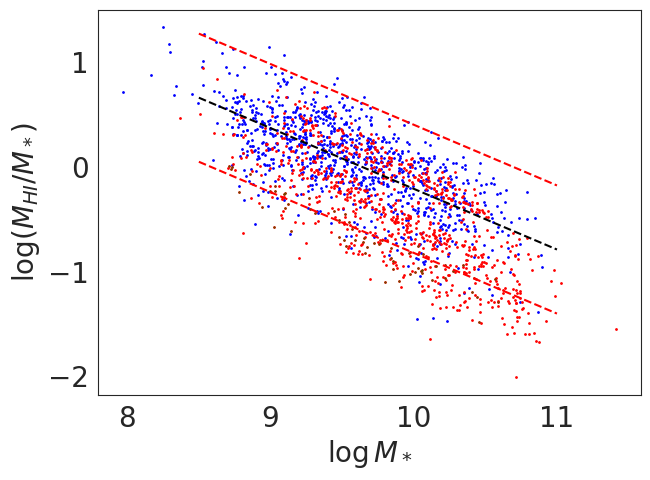

In [44]:
plt.figure(figsize=(7,5))
x = df_HI_d['LOGMSTARS']
y = df_HI_d['MHI_MST'] 

init = models.Linear1D()
fit = fitting.LinearLSQFitter()
model = fit(init,x,y)

std = np.std(model(x)-y)

sc = plt.scatter(x,y,s=1, color='blue')

x = df_HI_nd['LOGMSTARS']
y = df_HI_nd['MHI_MST'] 

sc = plt.scatter(x,y,s=1, color='red')

x = np.linspace(8.5,11)
plt.plot(x ,model(x), '--k')
plt.plot(x, model(x)- 2*std, '--r')
plt.plot(x, model(x)+ 2*std, '--r')

df_test = df_HI_nd[df_HI_nd['MHI_MST'] < model(df_HI_nd['LOGMSTARS']) - 0.5]
df_test = df_test[df_test['sSFR']>-10.8]

x = df_test['LOGMSTARS']
y = df_test['MHI_MST'] 

sc = plt.scatter(x,y,s=0.5, color='green', marker = '.')
plt.xlabel(r'$\log M_*$')
plt.ylabel(r'$\log(M_{HI}/M_*)$')
plt.show()

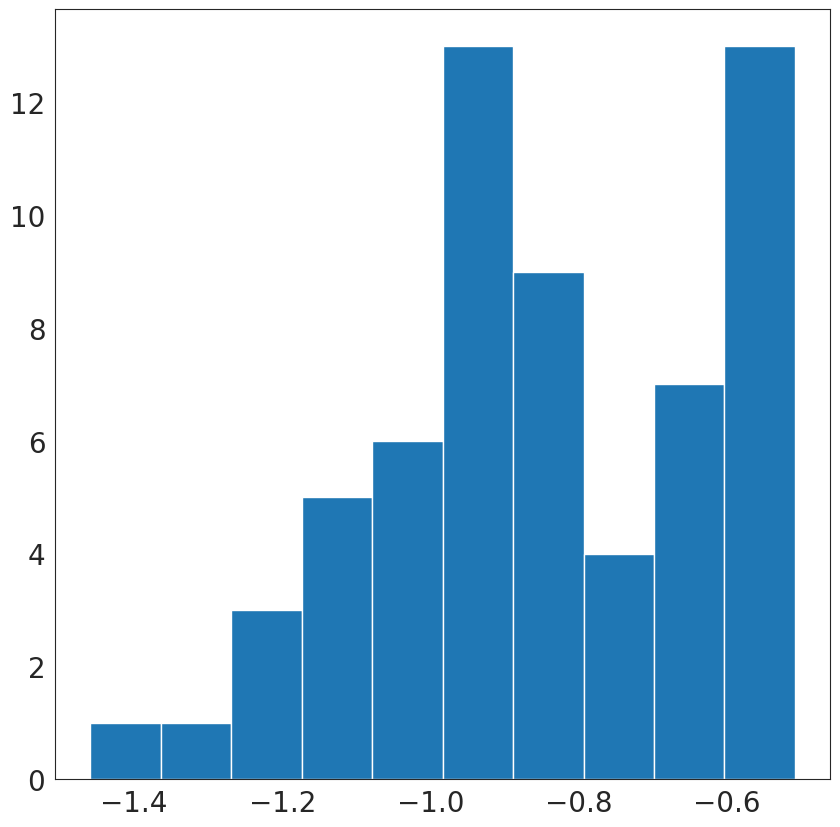

In [49]:
data = df_test['density']

plt.hist(data)
plt.show()

In [54]:
len(df_test)

62

In [55]:
df_test

name,plate,ifudsgn,plateifu_1,mangaid_1,objra_1,objdec_1,log_SFR_Ha,FoV,Re_kpc,e_log_Mass,e_log_SFR_Ha,log_Mass,log_SFR_ssp,log_NII_Ha_cen,e_log_NII_Ha_cen,log_OIII_Hb_cen,e_log_OIII_Hb_cen,log_SII_Ha_cen,e_log_SII_Ha_cen,log_OII_Hb_cen,e_log_OII_Hb_cen,EW_Ha_cen,e_EW_Ha_cen,ZH_LW_Re_fit,e_ZH_LW_Re_fit,alpha_ZH_LW_Re_fit,e_alpha_ZH_LW_Re_fit,ZH_MW_Re_fit,e_ZH_MW_Re_fit,alpha_ZH_MW_Re_fit,e_alpha_ZH_MW_Re_fit,Age_LW_Re_fit,e_Age_LW_Re_fit,alpha_Age_LW_Re_fit,e_alpha_Age_LW_Re_fit,Age_MW_Re_fit,e_Age_MW_Re_fit,alpha_Age_MW_Re_fit,e_alpha_Age_MW_Re_fit,Re_arc,DL,DA,PA,ellip,log_Mass_gas,vel_sigma_Re,e_vel_sigma_Re,log_SFR_SF,log_SFR_D_C,OH_O3N2_cen,e_OH_O3N2_cen,OH_N2_cen,e_OH_N2_cen,OH_ONS_cen,e_OH_ONS_cen,OH_R23_cen,e_OH_R23_cen,OH_pyqz_cen,e_OH_pyqz_cen,OH_t2_cen,e_OH_t2_cen,OH_M08_cen,e_OH_M08_cen,OH_T04_cen,e_OH_T04_cen,OH_dop_cen,e_OH_dop_cen,OH_O3N2_EPM09_cen,e_OH_O3N2_EPM09_cen,log_OI_Ha_cen,e_log_OI_Ha_cen,Ha_Hb_cen,e_Ha_Hb_cen,log_NII_Ha_Re,e_log_NII_Ha_Re,log_OIII_Hb_Re,e_log_OIII_Hb_Re,log_SII_Ha_Re,e_log_SII_Ha_Re,log_OII_Hb_Re,e_log_OII_Hb_Re,log_OI_Ha_Re,e_log_OI_Ha_Re,EW_Ha_Re,e_EW_Ha_Re,Ha_Hb_Re,e_Ha_Hb_Re,log_NII_Ha_ALL,e_log_NII_Ha_ALL,log_OIII_Hb_ALL,e_log_OIII_Hb_ALL,log_SII_Ha_ALL,e_log_SII_Ha_ALL,log_OII_Hb_ALL,e_log_OII_Hb_ALL,log_OI_Ha_ALL,e_log_OI_Ha_ALL,EW_Ha_ALL,e_EW_Ha_ALL,Ha_Hb_ALL,Sigma_Mass_cen,e_Sigma_Mass_cen,Sigma_Mass_Re,e_Sigma_Mass_Re,Sigma_Mass_ALL,e_Sigma_Mass_ALL,T30,ZH_T30,ZH_Re_T30,a_ZH_T30,T40,ZH_T40,ZH_Re_T40,a_ZH_T40,T50,ZH_T50,ZH_Re_T50,a_ZH_T50,T60,ZH_T60,ZH_Re_T60,a_ZH_T60,T70,ZH_T70,ZH_Re_T70,a_ZH_T70,T80,ZH_T80,ZH_Re_T80,a_ZH_T80,T90,ZH_T90,ZH_Re_T90,a_ZH_T90,T95,ZH_T95,ZH_Re_T95,a_ZH_T95,T99,ZH_T99,ZH_Re_T99,a_ZH_T99,log_Mass_gas_Av_gas_OH,log_Mass_gas_Av_ssp_OH,vel_ssp_2,e_vel_ssp_2,vel_Ha_2,e_vel_Ha_2,vel_ssp_1,e_vel_ssp_1,vel_Ha_1,e_vel_Ha_1,log_SFR_ssp_100Myr,log_SFR_ssp_10Myr,vel_disp_Ha_cen,vel_disp_ssp_cen,vel_disp_Ha_1Re,vel_disp_ssp_1Re,log_Mass_in_Re,ML_int,ML_avg,F_Ha_cen,e_F_Ha_cen,R50_kpc_V,e_R50_kpc_V,R50_kpc_Mass,e_R50_kpc_Mass,log_Mass_corr_in_R50_V,e_log_Mass_corr_in_R50_V,log_Mass_gas_Av_gas_log_log,Av_gas_Re,e_Av_gas_Re,Av_ssp_Re,e_Av_ssp_Re,Lambda_Re,e_Lambda_Re,nsa_redshift,nsa_mstar,nsa_inclination,flux_[OII]3726.03_Re_fit,e_flux_[OII]3726.03_Re_fit,flux_[OII]3726.03_alpha_fit,e_flux_[OII]3726.03_alpha_fit,flux_[OII]3728.82_Re_fit,e_flux_[OII]3728.82_Re_fit,flux_[OII]3728.82_alpha_fit,e_flux_[OII]3728.82_alpha_fit,flux_HI3734.37_Re_fit,e_flux_HI3734.37_Re_fit,flux_HI3734.37_alpha_fit,e_flux_HI3734.37_alpha_fit,flux_HI3797.9_Re_fit,e_flux_HI3797.9_Re_fit,flux_HI3797.9_alpha_fit,e_flux_HI3797.9_alpha_fit,flux_HeI3888.65_Re_fit,e_flux_HeI3888.65_Re_fit,flux_HeI3888.65_alpha_fit,e_flux_HeI3888.65_alpha_fit,flux_HI3889.05_Re_fit,e_flux_HI3889.05_Re_fit,flux_HI3889.05_alpha_fit,e_flux_HI3889.05_alpha_fit,flux_HeI3964.73_Re_fit,e_flux_HeI3964.73_Re_fit,flux_HeI3964.73_alpha_fit,e_flux_HeI3964.73_alpha_fit,flux_[NeIII]3967.46_Re_fit,e_flux_[NeIII]3967.46_Re_fit,flux_[NeIII]3967.46_alpha_fit,e_flux_[NeIII]3967.46_alpha_fit,flux_CaII3968.47_Re_fit,e_flux_CaII3968.47_Re_fit,flux_CaII3968.47_alpha_fit,e_flux_CaII3968.47_alpha_fit,flux_Hepsilon3970.07_Re_fit,e_flux_Hepsilon3970.07_Re_fit,flux_Hepsilon3970.07_alpha_fit,e_flux_Hepsilon3970.07_alpha_fit,flux_Hdelta4101.77_Re_fit,e_flux_Hdelta4101.77_Re_fit,flux_Hdelta4101.77_alpha_fit,e_flux_Hdelta4101.77_alpha_fit,flux_Hgamma4340.49_Re_fit,e_flux_Hgamma4340.49_Re_fit,flux_Hgamma4340.49_alpha_fit,e_flux_Hgamma4340.49_alpha_fit,flux_Hbeta4861.36_Re_fit,e_flux_Hbeta4861.36_Re_fit,flux_Hbeta4861.36_alpha_fit,e_flux_Hbeta4861.36_alpha_fit,flux_[OIII]4958.91_Re_fit,e_flux_[OIII]4958.91_Re_fit,flux_[OIII]4958.91_alpha_fit,e_flux_[OIII]4958.91_alpha_fit,flux_[OIII]5006.84_Re_fit,e_flux_[OIII]5006.84_Re_fit,flux_[OIII]5006.84_alpha_fit,e_flux_[OIII]5006.84_alpha_fit,flux_HeI5015.68_Re_fit,e_flux_HeI5015.68_Re_fit,flux_HeI5015.68_alpha_fit,e_flux_HeI5015.68_alpha_fit,flux_[NI]5197.9_Re_fit,e_flux_[NI]5197.9_Re_fit,flux_[NI]5197.9_a

## **GSWLC X2**

In [20]:
tab_HI = Table.read('../data/HI_MaNGA_GSWLC_X2.fits')

In [24]:
tab_HI['sSFR'] = tab_HI['logSFR'] - tab_HI['logMst']

In [96]:
df_HI = tab_HI[(tab_HI['conflag']==0) & (tab_HI['LOGMSTARS']>0) & (tab_HI['flag_sed']==0) ]

(-14.0, -9.0)

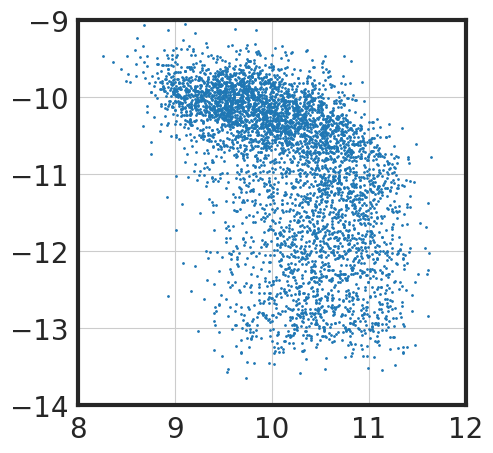

In [97]:
x = df_HI['logMst']
y = df_HI['sSFR']
plt.figure(figsize=(5,5))
plt.scatter(x,y, s=1)
plt.grid()
plt.xlim(8,12)
plt.ylim(-14,-9)

In [98]:
df_HI_d = df_HI[df_HI['LOGMHI']>0]
df_HI_nd = df_HI[ df_HI['LOGHILIM200KMS']>0]

In [99]:
df_HI_d['MHI_MST'] = df_HI_d['LOGMHI'] - df_HI_d['LOGMSTARS']
df_HI_nd['MHI_MST'] = df_HI_nd['LOGHILIM200KMS']- df_HI_nd['LOGMSTARS']

(-14.0, -9.0)

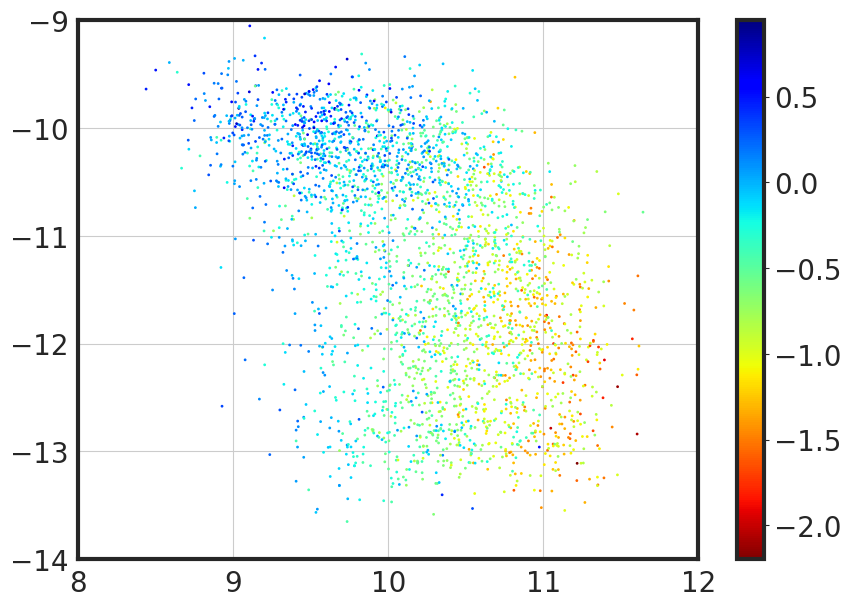

In [100]:
x = df_HI_nd['logMst']
y = df_HI_nd['sSFR']
c = df_HI_nd['MHI_MST']
plt.figure(figsize=(10,7))
img = plt.scatter(x,y,c=c, s=1, cmap='jet_r')
plt.colorbar(img)
plt.grid()
plt.xlim(8,12)
plt.ylim(-14,-9)

(-2.0, 1.0)

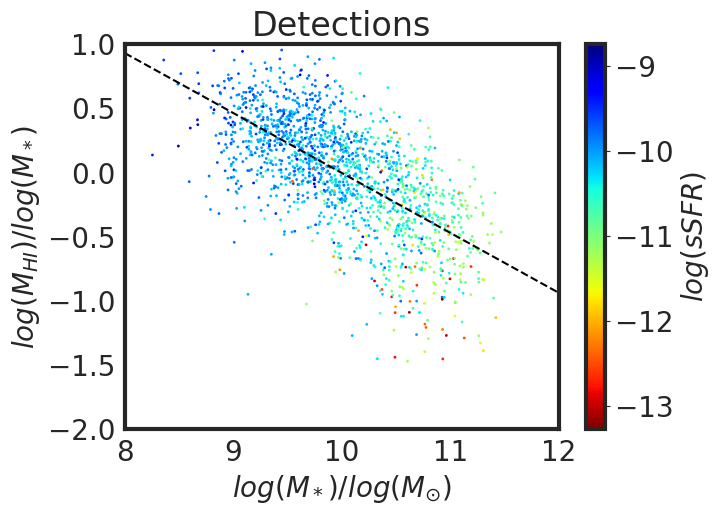

In [101]:
x = df_HI_d['logMst']
y = df_HI_d['MHI_MST']
c = df_HI_d['sSFR']

init = models.Linear1D(slope=0)
fit = fitting.LinearLSQFitter()
model = fit(init,x,y)

plt.figure(figsize=(7,5))
img = plt.scatter(x,y, s=1, c=c, cmap='jet_r')
cb = plt.colorbar(img)
M = np.linspace(8,12)
plt.plot(M,model(M), '--k')
cb.set_label(r'$log(sSFR)$')
plt.xlabel(r'$log(M_*)/log(M_{\odot})$')
plt.ylabel(r'$log(M_{HI})/log(M_*)$')
plt.title('Detections')

plt.xlim(8,12)
plt.ylim(-2,1)

(-2.0, 1.0)

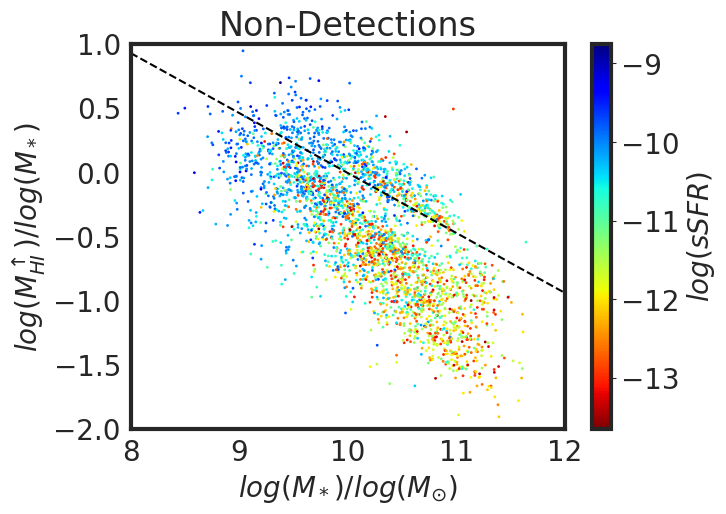

In [102]:
x = df_HI_nd['logMst']
y = df_HI_nd['MHI_MST']
c = df_HI_nd['sSFR']
plt.figure(figsize=(7,5))
img = plt.scatter(x,y, s=1, c=c, cmap='jet_r')
cb = plt.colorbar(img)
cb.set_label(r'$log(sSFR)$')

M = np.linspace(8,12)
plt.plot(M,model(M), '--k')

plt.xlabel(r'$log(M_*)/log(M_{\odot})$')
plt.ylabel(r'$log(M_{HI}^{\uparrow})/log(M_*)$')

plt.title('Non-Detections')
plt.xlim(8,12)
plt.ylim(-2,1)

(-2.0, 1.0)

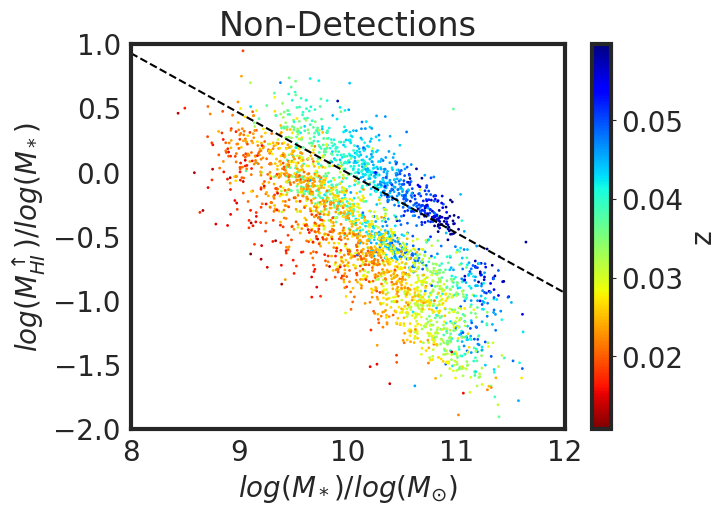

In [103]:
x = df_HI_nd['logMst']
y = df_HI_nd['MHI_MST']
c = df_HI_nd['z']
plt.figure(figsize=(7,5))
img = plt.scatter(x,y, s=1, c=c, cmap='jet_r')
cb = plt.colorbar(img)
cb.set_label(r'z')

M = np.linspace(8,12)
plt.plot(M,model(M), '--k')

plt.xlabel(r'$log(M_*)/log(M_{\odot})$')
plt.ylabel(r'$log(M_{HI}^{\uparrow})/log(M_*)$')

plt.title('Non-Detections')
plt.xlim(8,12)
plt.ylim(-2,1)

In [19]:
df_HI_dQ = df_HI_d[df_HI_d['sSFR']<-11.8]
df_HI_ndSF = df_HI_nd[df_HI_nd['sSFR']>-10.8]

Text(0, 0.5, '$log(M_{HI})/log(M_*)$')

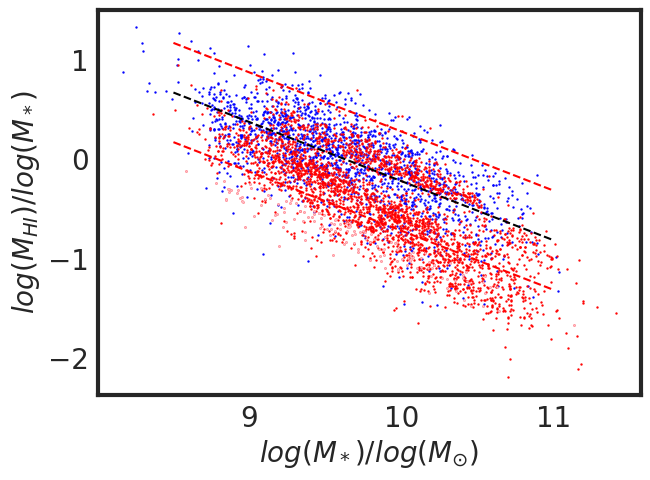

In [79]:
plt.figure(figsize=(7,5))
x = df_HI_d['LOGMSTARS']
y = df_HI_d['MHI_MST'] 

init = models.Linear1D(slope=0)
fit = fitting.LinearLSQFitter()
model = fit(init,x,y)

std = np.std(model(x)-y)

sc = plt.scatter(x,y,s=0.5, color='blue')

x = df_HI_nd['LOGMSTARS']
y = df_HI_nd['MHI_MST'] 

sc = plt.scatter(x,y,s=0.5, color='red')

x = np.linspace(8.5,11)
plt.plot(x ,model(x), '--k')
plt.plot(x, model(x)-0.5, '--r')
plt.plot(x, model(x)+0.5, '--r')

df_test = df_HI_nd[df_HI_nd['MHI_MST'] < model(df_HI_nd['LOGMSTARS']) - 2*std]
df_test = df_test[df_test['sSFR']>-10.8]

x = df_test['LOGMSTARS']
y = df_test['MHI_MST'] 

sc = plt.scatter(x,y,s=0.5, color='pink')

plt.xlabel(r'$log(M_*)/log(M_{\odot})$')
plt.ylabel(r'$log(M_{HI})/log(M_*)$')

In [71]:
model

<Linear1D(slope=-0.59496022, intercept=5.72838796)>

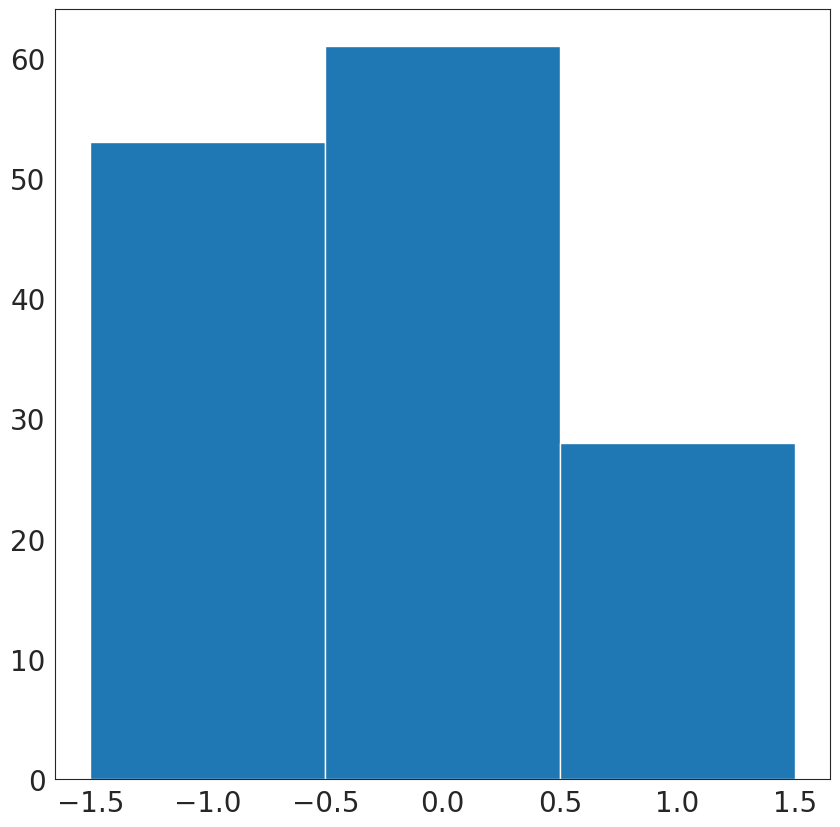

In [82]:
data = df_test['density']

plt.hist(data, bins=[-1.5,-0.5,0.5,1.5])
plt.show()

In [83]:
len(df_test)

143

# **Maps with Matplotlib**

## **Utils**

In [50]:
use_masks = ['NOCOV', 'UNRELIABLE', 'DONOTUSE']
def goodspax(dapmap, SNR = 1.0,type=None):
    if type==None:
        bad_data = dapmap.pixmask.get_mask(use_masks,dtype = bool)
        low_snr = dapmap.snr <= SNR
        mask = np.logical_or.reduce((bad_data, low_snr))
        mask = np.where(mask==True,np.nan,1)

    elif type=='vel':

        low_snr = dapmap.snr<=SNR
        bad_data = dapmap.pixmask.get_mask(use_masks,dtype = bool)
        mask = np.logical_or.reduce((bad_data, low_snr))
        mask = np.where(mask==True,1e-32,1)

    return dapmap.value*mask

In [51]:
def aperture_gen(models,angle_scale,len_scale, origin = 'center' , a_offset = 0):
    apertures = {}
    for i,model in enumerate(models):

        X_c = model[f'{i+1}_XC'].split('+')[0]
        if '*' in X_c:
          print('Error in X_c')
          X_c = float(X_c[1:-2])
        else:
          X_c = float(X_c)
        if origin == 'center':
          X_c-=64
        X_c*=(len_scale/128)

        Y_c = model[f'{i+1}_YC'].split('+')[0]
        if '*' in Y_c:
          print('Error in Y_c')
          Y_c = float(Y_c[1:-2])
        else:
          Y_c = float(Y_c)

        if origin == 'center':
          Y_c-=64
        Y_c*=(len_scale/128)

        PA = model[f'{i+1}_PA'].split('+')[0]
        if '*' in PA:
          print('Error in PA')
          PA = float(PA[1:-2])
        else:
          PA = float(PA)

        AR = model[f'{i+1}_AR'].split('+')[0]
        if '*' in AR:
          print('Error in AR')
          AR = float(AR[1:-2])
        else:
          AR = float(AR)


        keys = [i.split('_')[-1] for i in model.keys()]
        if'RE' in keys:
            RE = model[f'{i+1}_RE'].split('+')[0]
            if '*' in RE:
                print('Error in X_c')
                RE = float(RE[1:-2])
            else:
                RE = float(RE)

        else:
            RE = model[f'{i+1}_RS'].split('+')[0]
            if '*' in RE:
                print('Error in RS')
                RE = float(RE[1:-2])
            else:
                RE = float(RE)

        RE*=(0.394) # RE in arcseconds
        RE*angle_scale
        a = 2*RE
        b = AR*a
        print(a)
        aperture = aper.EllipticalAperture((X_c,Y_c), a,b,
                                           theta = np.pi/2 +(PA + a_offset)*np.pi/180)
        apertures[f'aper_{i+1}'] = aperture
    return apertures

In [52]:
def get_whan(maps):

    nii=maps.emli40ne_gflux_nii_6585
    ha =maps.emline_gflux_ha_6564
    niiha = nii/ha
    ewha = maps['emline_sew_ha_6564']
    ewnii = maps['emline_sew_nii_6585']
    # take the log of the NII/Ha ratio
    logniiha = np.log10(niiha.value)

    # create the WHAN categories
    psf  = (logniiha < -0.4)  & (ewha.value > 3)
    sagn = (logniiha > -0.4)  & (ewha.value > 6)
    wagn = (logniiha > -0.4)  & ((ewha.value > 3) & (ewha.value < 6))
    rg   = ewha.value < 3
    pg   = (ewha.value < 0.5) & (ewnii.value < 0.5)

    # create a custom array for a WHAN categories (we copy the EW Ha array just to get a 2d-array of the original size)
    value = ewha.value.copy()
    value[psf]  = 1     # pure star-forming
    value[sagn] = 2     # strong agn
    value[wagn] = 3     # weak agn
    value[rg]   = 4     # retired galaxies
    value[pg]   = 5     # passive galaxies

    # Set ivar to 0 where the SNR < 1
    niiha_low_snr = mapplot.mask_low_snr(niiha.value, niiha.ivar, snr_min=1)
    ewha_low_snr = mapplot.mask_low_snr(ewha.value, ewha.ivar, snr_min=1)
    ewnii_low_snr = mapplot.mask_low_snr(ewnii.value, ewnii.ivar, snr_min=1)
    low_snr = np.logical_or(niiha_low_snr, ewha_low_snr, ewnii_low_snr)

    ivar = ewha.value.copy()
    ivar[low_snr] = 0
    value[low_snr] = np.nan

    return value

## **Map Set 1**

In [53]:
matplotlib.rcParams['axes.linewidth'] = 3
matplotlib.rcParams['font.size'] = 20

In [59]:
plateifu

'10001-3702'

In [56]:
for plateifu in df_test['plateifu_1']:
    maps = Maps(plateifu=plateifu,mode='remote')
    mangaid = maps.mangaid

    gs = gridspec.GridSpec(ncols=4, nrows=2, width_ratios = [0.8,1,1,1], wspace=0.0001,hspace=0.1)
    fig = plt.figure(figsize = (70,30))

    # Set the size of image cutout
    scale = maps.wcs.to_header()['PC2_2']*3600
    size = 2*maps.wcs.to_header()['CRPIX1']*scale

    # Get SDSS Image
    optical=maps.getImage()

    ax = fig.add_subplot(gs[0,0], projection = optical.wcs)
    ax.imshow(optical.data, extent = [-1,1,-1,1])
    #ax.set_title('SDSS')
    ax.annotate(f'{mangaid}', (0.5,0.85), color = 'White', fontsize = 50)
    ax.axis('Off')

    # Crop Image to match IFU size

    optical.get_new_cutout(size,size,size/512)
    filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
    levels=[60.,  90., 120., 150., 180., 210., 240.]
    scale_s = optical.wcs.to_header()['PC2_2']*3600
    size_s  = 2*optical.wcs.to_header()['CRPIX1']*scale_s

    # Decals
    img = Cutout_L(ra = optical.ra, dec = optical.dec, width = size_s, height=size_s, scale = size_s/512 )

    ax1 = fig.add_subplot(gs[1,0], projection = img.wcs)
    ax1.grid(False)
    ax1.imshow(img.image)
    optical.overlay_hexagon(ax1, linewidth = 5)
    #ax1.set_title('DeCals')
    ax1.axis('Off')
    ax1.grid(False)

    # H alpha

    ax = fig.add_subplot(gs[0,1], projection=maps.wcs,slices=('x','y',0))
    ha = maps.emline_gflux_ha_6564

    ax.grid(False)
    cbr = mapplot.plot(dapmap=np.log10(ha),return_cbrange=True)

    img = ax.imshow((goodspax(ha,SNR = 3)),cmap='plasma')
    ax.grid(False)
    ax.set_autoscale_on(False)
    ax.contour(filter_r, transform=ax.get_transform(optical.wcs), colors='black',levels=levels,zorder=11,
              linewidths = 3)
    ax.tick_params(which='both', length=15, width = 2,direction="in", labelsize = 1)

    #ax.set_title(r'$H_{\alpha}$ Guassian Flux')
    ax.set_xlabel(' ')
    ax.set_ylabel(' ')

    cb=plt.colorbar(img,ax=ax, shrink=1, anchor = (-0.1,0.5))
    cb.set_label(r'$1\times10^{-17}erg.cm^{-2}.s^{-1}$', labelpad = 5, fontsize = 30)
    cb.ax.tick_params(labelsize=40)

    # BPT
    ax4 = fig.add_subplot(gs[0,2],projection=maps.wcs,slices=('x','y',0))
    m, f ,a = maps.get_bpt(show_plot=False)

    SF   = m['sf']['global'].astype('float64')*5
    COMP = m['comp']['global'].astype('float64')*4
    LIN  = m['liner']['global'].astype('float64')*3
    SEY  = m['seyfert']['global'].astype('float64')*2
    AMB  = m['ambiguous']['global'].astype('float64')*1

    bpt = SF + COMP + LIN + SEY + AMB

    cmap = colors.ListedColormap(['grey','red', 'purple', 'green', 'cyan'])

    bpt[bpt==0]=np.nan
    img = ax4.imshow(bpt,cmap=cmap,vmin=0.5,vmax=5.5)
    ax4.set_autoscale_on(False)
    ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='black',levels=levels,zorder=11,
               linewidths = 3)
    ax4.tick_params(which='both', length=15, width = 2,direction="in", labelsize = 1)
    #ax4.set_title('BPT')
    ax4.set_xlabel(' ')
    ax4.set_ylabel(' ')

    cb=plt.colorbar(img, ax=ax4, shrink=1, anchor = (-0.1,0.5))
    cb.set_ticks([1.3, 2.3, 3.3, 4.2, 5])
    cb.set_ticklabels(['Unclear','Seyfert','LINER','Comp', 'SF'], rotation = 90,fontsize = 30)
    cb.ax.tick_params(labelsize=40)

    # WHAN

    ax4 = fig.add_subplot(gs[0,3],projection=maps.wcs,slices=('x','y',0))
    # WHAN Map

    # grab the NII/Ha flux ratio, Ha and NII equivalent width arrays
    nii=maps.emli40ne_gflux_nii_6585
    ha =maps.emline_gflux_ha_6564
    niiha = nii/ha
    ewha = maps['emline_sew_ha_6564']
    ewnii = maps['emline_sew_nii_6585']
    # take the log of the NII/Ha ratio
    logniiha = np.log10(niiha.value)

    # create the WHAN categories
    psf  = (logniiha < -0.4)  & (ewha.value > 3)
    sagn = (logniiha > -0.4)  & (ewha.value > 6)
    wagn = (logniiha > -0.4)  & ((ewha.value > 3) & (ewha.value < 6))
    rg   = ewha.value < 3
    pg   = (ewha.value < 0.5) & (ewnii.value < 0.5)

    # create a custom array for a WHAN categories (we copy the EW Ha array just to get a 2d-array of the original size)
    value = ewha.value.copy()
    value[psf]  = 1     # pure star-forming
    value[sagn] = 2     # strong agn
    value[wagn] = 3     # weak agn
    value[rg]   = 4     # retired galaxies
    value[pg]   = 5     # passive galaxies

    # Set ivar to 0 where the SNR < 1
    niiha_low_snr = mapplot.mask_low_snr(niiha.value, niiha.ivar, snr_min=3)
    ewha_low_snr = mapplot.mask_low_snr(ewha.value, ewha.ivar, snr_min=3)
    ewnii_low_snr = mapplot.mask_low_snr(ewnii.value, ewnii.ivar, snr_min=3)
    low_snr = np.logical_or(niiha_low_snr, ewha_low_snr, ewnii_low_snr)

    ivar = ewha.value.copy()
    ivar[low_snr] = 0
    value[low_snr] = np.nan


    # WHAN IFU
    cmap = colors.ListedColormap(['red', 'blue', 'goldenrod', 'green', 'purple'])
    nocov = ewha.pixmask.get_mask('NOCOV',dtype=bool)
    mask = np.where(nocov==True,np.nan,1)
    img = ax4.imshow(value,cmap=cmap,vmin=0.5,vmax=5.5)
    ax4.set_autoscale_on(False)
    ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='black',levels=levels,zorder=11,
               linewidths = 3)

    ax4.tick_params(which='both', length=15, width = 2,direction="in", labelsize = 1)
    #ax4.set_title('WHAN')
    ax4.set_xlabel(' ')
    ax4.set_ylabel(' ')

    cb=plt.colorbar(img,ax=ax4, shrink=1, anchor = (-0.1,0.5))
    cb.set_ticks([1, 2, 3, 4, 5])
    cb.set_ticklabels(['PSF', 'SAGN', 'WAGN', 'RG', 'PG'], rotation = 90, fontsize=40)
    cb.ax.tick_params(labelsize=40)

    # sSFR

    hb = maps.emline_gflux_hb_4862
    ha_hb = maps.getMapRatio('emline_gflux','ha_6564','hb_4862')

    sf       = m['sf']['global'].astype('float64')
    segm      = detect_sources(sf, 0, npixels = 5)
    flag = 0
    if not isinstance(segm,type(None)):
        cat = SourceCatalog(sf, segm).to_table()
        if cat['area'].value.max()<=10:
            flag = 1
    else:
        flag = 1

    if flag:
        value = get_whan(maps);
        sf = np.where(value ==1, 1, np.nan)
        segm      = detect_sources(sf, 0, npixels = 5)
        if not isinstance(segm,type(None)):
            cat = SourceCatalog(sf, segm).to_table()
            area = cat['area'].value.max()
        else:
            area = 0
    else:
        sf = np.where(sf ==1, 1, np.nan)
        area  = cat['area'].value.max()

    ha_sf    = goodspax(ha,3)*sf
    hb_sf    = goodspax(hb,3)*sf
    ha_hb_sf = goodspax(ha_hb,3)*sf

    z = maps.dapall['z']

    fa = ha_sf*1e-17*pow(10,2.468*0.934*np.log(ha_hb_sf/2.86))
    D_L = cosmo.luminosity_distance(z).to(u.cm)
    Lha =  (fa*4*np.pi*D_L*D_L)*(u.erg/u.second)
    SFR = pow(10,-41.1)*Lha
    SFR = SFR*(u.solMass/u.year)

    cube = maps.getCube()

    M = cube.vacs.firefly['mastar']._make_map('stellar_mass')
    M = 10**np.where(M>-10,M,0)
    M = M*(u.solMass)

    sSFR = SFR/M
    ax4 = fig.add_subplot(gs[1,1],projection=maps.wcs,slices=('x','y',0))
    ax4.grid(False)

    img = ax4.imshow(np.log10(sSFR.value), cmap = 'jet')
    ax4.grid(False)
    ax4.set_autoscale_on(False)
    ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='black',levels=levels,zorder=11,
               linewidths = 3)
    ax4.tick_params(which='both', length=15, width = 2,direction="in", labelsize = 1)
    #ax4.set_title('Log sSFR')
    ax4.set_xlabel(' ')
    ax4.set_ylabel(' ')

    cb=plt.colorbar(img,ax=ax4, shrink=1, anchor = (-0.1,0.5))
    cb.set_label(r' $[yr^{-1}]$', labelpad =15, fontsize=30)
    cb.ax.tick_params(labelsize=40)

    # Metallicity
    n2 = niiha*sf
    logn2 = np.log10(n2)
    logoh = 8.90 + 0.57 * logn2

    mask_bad_data = n2.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
    min_snr = 3.
    mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
    mask_ha_low_snr = (np.abs(ha.value * np.sqrt(ha.ivar)) < min_snr)

    mask =  (mask_bad_data | mask_nii_low_snr | mask_ha_low_snr).astype(bool)
    ax3 = fig.add_subplot(gs[1,2], projection=maps.wcs,slices=('x','y',0))
    ax3.grid(False)
    cbr = mapplot.plot(dapmap=logoh,mask=mask,return_cbrange=True)
    mask = np.where(mask==True,np.nan,1)
    img = ax3.imshow(logoh.value*mask,vmin = 8, vmax = 8.9, cmap = 'viridis')
    ax3.grid(False)
    ax3.set_autoscale_on(False)
    ax3.contour(filter_r, transform=ax3.get_transform(optical.wcs), colors='black',
              levels=levels,zorder=11, linewidths = 3)
    ax3.tick_params(which='both', length=15, width = 2,direction="in", labelsize = 1)

    ax3.set_xlabel(' ')
    ax3.set_ylabel(' ')
    #ax3.set_title('Gas Phase Metallicity')

    cb=plt.colorbar(img,ax=ax3, shrink=1, anchor = (-0.1,0.5))
    cb.set_label(r'12+log(O/H)', labelpad = 5, fontsize=40)
    cb.ax.tick_params(labelsize=40)

    # DN4000

    ax4 = fig.add_subplot(gs[1,3], projection=maps.wcs,slices=('x','y',0))
    dn=maps.specindex_dn4000

    dn = dn*sf

    ax4.grid(False)
    img = ax4.imshow(goodspax(dn,3) ,cmap='inferno', vmin = 1, vmax = 1.9)
    ax4.grid(False)
    ax4.set_autoscale_on(False)
    ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='black',levels=levels,zorder=11,
               linewidths = 3)
    ax4.tick_params(which='both', length=15, width = 2,direction="in", labelsize = 1)
    #ax4.set_title('Dn4000')
    ax4.set_xlabel(' ')
    ax4.set_ylabel(' ')

    cb=plt.colorbar(img,ax=ax4, shrink=1, anchor = (-0.1,0.5))
    cb.ax.tick_params(labelsize=40)

    #fig.suptitle(f"MANGAID: {mangaid} | PLATEIFU: {plateifu} | SF area : {area}",y = 0.9)

    fig.savefig(f'../images/isolated_HI_def/{mangaid}_{plateifu}.png',bbox_inches='tight');
    
    plt.close(fig)
    print(mangaid)

[ERROR]: Traceback (most recent call last):
  File "/home/avinashck/anaconda3/envs/manga/lib/python3.11/site-packages/brain/api/api.py", line 201, in _checkResponse
    isbad = response.raise_for_status()
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/avinashck/anaconda3/envs/manga/lib/python3.11/site-packages/requests/models.py", line 1021, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 409 Client Error: CONFLICT for url: https://magrathea.sdss.org/marvin/api/maps/10001-3702/HYB10/MILESHC-MASTARSSP/

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/avinashck/anaconda3/envs/manga/lib/python3.11/site-packages/marvin/tools/maps.py", line 378, in _load_maps_from_api
    response = self._toolInteraction(url_full)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/avinashck/anaconda3/envs/manga/lib/python3.11/site-packages/marvin/tools/core.py", line 1

In [ ]:
pow(10, 0.5)

In [ ]:
df_test.keys()

## **Maps Set 2**

In [ ]:
for mangaid in ids_[15:]:
    plateifu = tab_HI_def_M[tab_HI_def_M['mangaid']==mangaid]['plateifu'].value[0]
    gassid   = tab_HI_def_M[tab_HI_def_M['mangaid']==mangaid]['GASS'].value[0]
    maps = Maps(plateifu=plateifu,mode='remote')
    mangaid = maps.mangaid

    gs = gridspec.GridSpec(ncols=4, nrows=1, width_ratios = [0.8,0.8,1,1], wspace=0.0001,hspace=0.1)
    fig = plt.figure(figsize = (70,15))

    # Set the size of image cutout
    scale = maps.wcs.to_header()['PC2_2']*3600
    size = 2*maps.wcs.to_header()['CRPIX1']*scale

    # Get SDSS Image
    optical=maps.getImage()

    ax = fig.add_subplot(gs[0], projection = optical.wcs)
    ax.imshow(optical.data, extent = [-1,1,-1,1])
    #ax.set_title('SDSS')
    ax.annotate(f'{gassid}', (0.5,0.85), color = 'White', fontsize = 50)
    ax.axis('Off')

    # Crop Image to match IFU size

    optical.get_new_cutout(size,size,size/512)
    filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
    levels=[60.,  90., 120., 150., 180., 210., 240.]
    scale_s = optical.wcs.to_header()['PC2_2']*3600
    size_s  = 2*optical.wcs.to_header()['CRPIX1']*scale_s

    # Decals
    img = Cutout_L(ra = optical.ra, dec = optical.dec, width = size_s, height=size_s, scale = size_s/512 )

    ax1 = fig.add_subplot(gs[1], projection = img.wcs)
    ax1.grid(False)
    ax1.imshow(img.image)
    optical.overlay_hexagon(ax1, linewidth = 5)
    #ax1.set_title('DeCals')
    ax1.axis('Off')
    ax1.grid(False)

    # BPT
    ax4 = fig.add_subplot(gs[2],projection=maps.wcs,slices=('x','y',0))
    m, f ,a = maps.get_bpt(show_plot=False)

    SF   = m['sf']['global'].astype('float64')*5
    COMP = m['comp']['global'].astype('float64')*4
    LIN  = m['liner']['global'].astype('float64')*3
    SEY  = m['seyfert']['global'].astype('float64')*2
    AMB  = m['ambiguous']['global'].astype('float64')*1

    bpt = SF + COMP + LIN + SEY + AMB

    cmap = colors.ListedColormap(['grey','red', 'purple', 'green', 'cyan'])

    bpt[bpt==0]=np.nan
    img = ax4.imshow(bpt,cmap=cmap,vmin=0.5,vmax=5.5)
    ax4.set_autoscale_on(False)
    ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='black',levels=levels,zorder=11,
               linewidths = 3)
    ax4.tick_params(which='both', length=15, width = 2,direction="in", labelsize = 1)
    #ax4.set_title('BPT')
    ax4.set_xlabel(' ')
    ax4.set_ylabel(' ')

    cb=plt.colorbar(img, ax=ax4, shrink=1, anchor = (-0.1,0.5))
    cb.set_ticks([1.3, 2.3, 3.3, 4.2, 5])
    cb.set_ticklabels(['Unclear','Seyfert','LINER','Comp', 'SF'], rotation = 90,fontsize = 30)
    cb.ax.tick_params(labelsize=40)

    # WHAN

    ax4 = fig.add_subplot(gs[3],projection=maps.wcs,slices=('x','y',0))
    # WHAN Map

    # grab the NII/Ha flux ratio, Ha and NII equivalent width arrays
    nii=maps.emli40ne_gflux_nii_6585
    ha =maps.emline_gflux_ha_6564
    niiha = nii/ha
    ewha = maps['emline_sew_ha_6564']
    ewnii = maps['emline_sew_nii_6585']
    # take the log of the NII/Ha ratio
    logniiha = np.log10(niiha.value)

    # create the WHAN categories
    psf  = (logniiha < -0.4)  & (ewha.value > 3)
    sagn = (logniiha > -0.4)  & (ewha.value > 6)
    wagn = (logniiha > -0.4)  & ((ewha.value > 3) & (ewha.value < 6))
    rg   = ewha.value < 3
    pg   = (ewha.value < 0.5) & (ewnii.value < 0.5)

    # create a custom array for a WHAN categories (we copy the EW Ha array just to get a 2d-array of the original size)
    value = ewha.value.copy()
    value[psf]  = 1     # pure star-forming
    value[sagn] = 2     # strong agn
    value[wagn] = 3     # weak agn
    value[rg]   = 4     # retired galaxies
    value[pg]   = 5     # passive galaxies

    # Set ivar to 0 where the SNR < 1
    niiha_low_snr = mapplot.mask_low_snr(niiha.value, niiha.ivar, snr_min=3)
    ewha_low_snr = mapplot.mask_low_snr(ewha.value, ewha.ivar, snr_min=3)
    ewnii_low_snr = mapplot.mask_low_snr(ewnii.value, ewnii.ivar, snr_min=3)
    low_snr = np.logical_or(niiha_low_snr, ewha_low_snr, ewnii_low_snr)

    ivar = ewha.value.copy()
    ivar[low_snr] = 0
    value[low_snr] = np.nan


    # WHAN IFU
    cmap = colors.ListedColormap(['red', 'blue', 'goldenrod', 'green', 'purple'])
    nocov = ewha.pixmask.get_mask('NOCOV',dtype=bool)
    mask = np.where(nocov==True,np.nan,1)
    img = ax4.imshow(value,cmap=cmap,vmin=0.5,vmax=5.5)
    ax4.set_autoscale_on(False)
    ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='black',levels=levels,zorder=11,
               linewidths = 3)

    ax4.tick_params(which='both', length=15, width = 2,direction="in", labelsize = 1)
    #ax4.set_title('WHAN')
    ax4.set_xlabel(' ')
    ax4.set_ylabel(' ')

    cb=plt.colorbar(img,ax=ax4, shrink=1, anchor = (-0.1,0.5))
    cb.set_ticks([1, 2, 3, 4, 5])
    cb.set_ticklabels(['PSF', 'SAGN', 'WAGN', 'RG', 'PG'], rotation = 90, fontsize=40)
    cb.ax.tick_params(labelsize=40)

    fig.savefig(f'Q/{mangaid}_{plateifu}.png',bbox_inches='tight');

    print(mangaid)

## **Maps Set 3**

In [ ]:
for plateifu in HI_def['PLATEIFU']:

    maps = Maps(plateifu=plateifu,mode='remote')
    mangaid = maps.mangaid

    gs = gridspec.GridSpec(ncols=4, nrows=3, width_ratios = [0.8,1,1,1], wspace=0.0001,hspace=0.1)
    fig = plt.figure(figsize = (70,45))

    # Set the size of image cutout
    scale = maps.wcs.to_header()['PC2_2']*3600
    size = 2*maps.wcs.to_header()['CRPIX1']*scale

    # Get SDSS Image
    optical=maps.getImage()

    ax = fig.add_subplot(gs[0,0], projection = optical.wcs)
    ax.imshow(optical.data, extent = [-1,1,-1,1])
    ax.set_title('SDSS')
    ax.annotate(f'{mangaid}', (0.5,0.85), color = 'White', fontsize = 50)
    ax.axis('Off')

    # Crop Image to match IFU size

    optical.get_new_cutout(size,size,size/512)
    filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
    levels=[60.,  90., 120., 150., 180., 210., 240.]
    scale_s = optical.wcs.to_header()['PC2_2']*3600
    size_s  = 2*optical.wcs.to_header()['CRPIX1']*scale_s

    # Decals
    img = Cutout_L(ra = optical.ra, dec = optical.dec, width = size_s, height=size_s, scale = size_s/512 )

    ax1 = fig.add_subplot(gs[1,0], projection = img.wcs)
    ax1.grid(False)
    ax1.imshow(img.image)
    optical.overlay_hexagon(ax1, linewidth = 5)
    ax1.set_title('DeCals')
    ax1.axis('Off')
    ax1.grid(False)

    # H alpha

    ax = fig.add_subplot(gs[0,1], projection=maps.wcs,slices=('x','y',0))
    ha = maps.emline_gflux_ha_6564

    ax.grid(False)
    cbr = mapplot.plot(dapmap=np.log10(ha),return_cbrange=True)

    img = ax.imshow((goodspax(ha,SNR = 3)),cmap='plasma')
    ax.grid(False)
    ax.set_autoscale_on(False)
    ax.contour(filter_r, transform=ax.get_transform(optical.wcs), colors='black',levels=levels,zorder=11,
              linewidths = 3)
    ax.tick_params(which='both', length=15, width = 2,direction="in", labelsize = 1)

    ax.set_title(r'$H_{\alpha}$ Guassian Flux')
    ax.set_xlabel(' ')
    ax.set_ylabel(' ')

    cb=plt.colorbar(img,ax=ax, shrink=1, anchor = (-0.1,0.5))
    cb.set_label(r'$1\times10^{-17}erg.cm^{-2}.s^{-1}$', labelpad = 5, fontsize = 30)
    cb.ax.tick_params(labelsize=40)

    # BPT
    ax4 = fig.add_subplot(gs[0,2],projection=maps.wcs,slices=('x','y',0))
    m, f ,a = maps.get_bpt(show_plot=False)

    SF   = m['sf']['global'].astype('float64')*5
    COMP = m['comp']['global'].astype('float64')*4
    LIN  = m['liner']['global'].astype('float64')*3
    SEY  = m['seyfert']['global'].astype('float64')*2
    AMB  = m['ambiguous']['global'].astype('float64')*1

    bpt = SF + COMP + LIN + SEY + AMB

    cmap = colors.ListedColormap(['grey','red', 'purple', 'green', 'cyan'])

    bpt[bpt==0]=np.nan
    img = ax4.imshow(bpt,cmap=cmap,vmin=0.5,vmax=5.5)
    ax4.set_autoscale_on(False)
    ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='black',levels=levels,zorder=11,
               linewidths = 3)
    ax4.tick_params(which='both', length=15, width = 2,direction="in", labelsize = 1)
    #ax4.set_title('BPT')
    ax4.set_xlabel(' ')
    ax4.set_ylabel(' ')

    cb=plt.colorbar(img, ax=ax4, shrink=1, anchor = (-0.1,0.5))
    cb.set_ticks([1.3, 2.3, 3.3, 4.2, 5])
    cb.set_ticklabels(['Unclear','Seyfert','LINER','Comp', 'SF'], rotation = 90,fontsize = 30)
    cb.ax.tick_params(labelsize=40)

    # WHAN

    ax4 = fig.add_subplot(gs[0,3],projection=maps.wcs,slices=('x','y',0))
    # WHAN Map

    # grab the NII/Ha flux ratio, Ha and NII equivalent width arrays
    nii=maps.emli40ne_gflux_nii_6585
    ha =maps.emline_gflux_ha_6564
    niiha = nii/ha
    ewha = maps['emline_sew_ha_6564']
    ewnii = maps['emline_sew_nii_6585']
    # take the log of the NII/Ha ratio
    logniiha = np.log10(niiha.value)

    # create the WHAN categories
    psf  = (logniiha < -0.4)  & (ewha.value > 3)
    sagn = (logniiha > -0.4)  & (ewha.value > 6)
    wagn = (logniiha > -0.4)  & ((ewha.value > 3) & (ewha.value < 6))
    rg   = ewha.value < 3
    pg   = (ewha.value < 0.5) & (ewnii.value < 0.5)

    # create a custom array for a WHAN categories (we copy the EW Ha array just to get a 2d-array of the original size)
    value = ewha.value.copy()
    value[psf]  = 1     # pure star-forming
    value[sagn] = 2     # strong agn
    value[wagn] = 3     # weak agn
    value[rg]   = 4     # retired galaxies
    value[pg]   = 5     # passive galaxies

    # Set ivar to 0 where the SNR < 1
    niiha_low_snr = mapplot.mask_low_snr(niiha.value, niiha.ivar, snr_min=3)
    ewha_low_snr = mapplot.mask_low_snr(ewha.value, ewha.ivar, snr_min=3)
    ewnii_low_snr = mapplot.mask_low_snr(ewnii.value, ewnii.ivar, snr_min=3)
    low_snr = np.logical_or(niiha_low_snr, ewha_low_snr, ewnii_low_snr)

    ivar = ewha.value.copy()
    ivar[low_snr] = 0
    value[low_snr] = np.nan


    # WHAN IFU
    cmap = colors.ListedColormap(['red', 'blue', 'goldenrod', 'green', 'purple'])
    nocov = ewha.pixmask.get_mask('NOCOV',dtype=bool)
    mask = np.where(nocov==True,np.nan,1)
    img = ax4.imshow(value,cmap=cmap,vmin=0.5,vmax=5.5)
    ax4.set_autoscale_on(False)
    ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='black',levels=levels,zorder=11,
               linewidths = 3)

    ax4.tick_params(which='both', length=15, width = 2,direction="in", labelsize = 1)
    #ax4.set_title('WHAN')
    ax4.set_xlabel(' ')
    ax4.set_ylabel(' ')

    cb=plt.colorbar(img,ax=ax4, shrink=1, anchor = (-0.1,0.5))
    cb.set_ticks([1, 2, 3, 4, 5])
    cb.set_ticklabels(['PSF', 'SAGN', 'WAGN', 'RG', 'PG'], rotation = 90, fontsize=40)
    cb.ax.tick_params(labelsize=40)


    # Stellar Velocity
    vel_sigma = maps.stellar_sigma

    ax4 = fig.add_subplot(gs[1,1],projection=maps.wcs,slices=('x','y',0))
    ax4.grid(False)
    img = ax4.imshow(goodspax(vel_sigma,3) ,cmap='RdBu_r')
    ax4.grid(False)
    ax4.set_autoscale_on(False)
    ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs),
                colors='black',levels=levels,zorder=11,
                linewidths = 3)

    ax4.tick_params(which='both', length=15, width = 2,direction="in", labelsize = 1)
    ax4.set_title('Stellar Velocity')
    ax4.set_xlabel(' ')
    ax4.set_ylabel(' ')

    cb=plt.colorbar(img,ax=ax4, shrink=1, anchor = (-0.1,0.5))
    cb.ax.tick_params(labelsize=40)

     # H alpha Velocity
    havel = maps['emline_gvel_ha_6564']

    ax4 = fig.add_subplot(gs[1,2],projection=maps.wcs,slices=('x','y',0))
    ax4.grid(False)
    img = ax4.imshow(goodspax(havel,3) ,cmap='RdBu_r')
    ax4.grid(False)
    ax4.set_autoscale_on(False)
    ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs),
                colors='black',levels=levels,zorder=11,
                linewidths = 3)

    ax4.tick_params(which='both', length=15, width = 2,direction="in", labelsize = 1)
    ax4.set_title(r'$H_{\alpha}$ Velocity')
    ax4.set_xlabel(' ')
    ax4.set_ylabel(' ')

    cb=plt.colorbar(img,ax=ax4, shrink=1, anchor = (-0.1,0.5))
    cb.ax.tick_params(labelsize=40)

    # [OI] velocity

    ovel = maps['emline_gvel_oi_5007']

    ax4 = fig.add_subplot(gs[1,3],projection=maps.wcs,slices=('x','y',0))
    ax4.grid(False)
    img = ax4.imshow(goodspax(ovel,3) ,cmap='RdBu_r')
    ax4.grid(False)
    ax4.set_autoscale_on(False)
    ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs),
                colors='black',levels=levels,zorder=11,
                linewidths = 3)

    ax4.tick_params(which='both', length=15, width = 2,direction="in", labelsize = 1)
    ax4.set_title(r'$[OI]$ Velocity')
    ax4.set_xlabel(' ')
    ax4.set_ylabel(' ')

    cb=plt.colorbar(img,ax=ax4, shrink=1, anchor = (-0.1,0.5))
    cb.ax.tick_params(labelsize=40)


     # OI/ha

    oi = maps.emline_gflux_oi_5007

    oi_ha = oi/ha
    ax4 = fig.add_subplot(gs[2,0],projection=maps.wcs,slices=('x','y',0))
    ax4.grid(False)
    img = ax4.imshow(goodspax(oi_ha,3) ,cmap='inferno')
    ax4.grid(False)
    ax4.set_autoscale_on(False)
    ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs),
                colors='red',levels=levels,zorder=11,
                linewidths = 3)

    ax4.tick_params(which='both', length=15, width = 2,direction="in", labelsize = 1)
    ax4.set_title(r'$[OI]/H_{\alpha}$')
    ax4.set_xlabel(' ')
    ax4.set_ylabel(' ')

    cb=plt.colorbar(img,ax=ax4, shrink=0.8, anchor = (-0.1,0.5))
    cb.ax.tick_params(labelsize=40)

    # Stellar Dispersion

    vel_sigma = maps.stellar_sigma

    ax4 = fig.add_subplot(gs[2,1],projection=maps.wcs,slices=('x','y',0))
    ax4.grid(False)
    img = ax4.imshow(goodspax(vel_sigma,3) ,cmap='jet')
    ax4.grid(False)
    ax4.set_autoscale_on(False)
    #ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs),
    #            colors='black',levels=levels,zorder=11,
     #           linewidths = 3)

    ax4.tick_params(which='both', length=15, width = 2,direction="in", labelsize = 1)
    ax4.set_title(r'Stellar Velocity Dispersion')
    ax4.set_xlabel(' ')
    ax4.set_ylabel(' ')

    cb=plt.colorbar(img,ax=ax4, shrink=1, anchor = (-0.1,0.5))
    cb.ax.tick_params(labelsize=40)

     # Ha Velcoity Dispersion

    ha_sigma = maps.emline_gsigma_ha_6564

    ax4 = fig.add_subplot(gs[2,2],projection=maps.wcs,slices=('x','y',0))
    ax4.grid(False)
    img = ax4.imshow(goodspax(ha_sigma,3) ,cmap='jet')
    ax4.grid(False)
    ax4.set_autoscale_on(False)
    #ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs),
   #             colors='black',levels=levels,zorder=11,
   #             linewidths = 3)

    ax4.tick_params(which='both', length=15, width = 2,direction="in", labelsize = 1)
    ax4.set_title(r'$H_{\alpha}$ Velocity Dispersion')
    ax4.set_xlabel(' ')
    ax4.set_ylabel(' ')

    cb=plt.colorbar(img,ax=ax4, shrink=1, anchor = (-0.1,0.5))
    cb.ax.tick_params(labelsize=40)

     # Ha Velcoity Dispersion

    oi_sigma = maps.emline_gsigma_oi_5007

    ax4 = fig.add_subplot(gs[2,3],projection=maps.wcs,slices=('x','y',0))
    ax4.grid(False)
    img = ax4.imshow(goodspax(oi_sigma,3) ,cmap='jet')
    ax4.grid(False)
    ax4.set_autoscale_on(False)
    #ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs),
     #           colors='black',levels=levels,zorder=11,
      #          linewidths = 3)

    ax4.tick_params(which='both', length=15, width = 2,direction="in", labelsize = 1)
    ax4.set_title(r'$[OI]$ Velocity Dispersion')
    ax4.set_xlabel(' ')
    ax4.set_ylabel(' ')

    cb=plt.colorbar(img,ax=ax4, shrink=1, anchor = (-0.1,0.5))
    cb.ax.tick_params(labelsize=40)
    fig.savefig(f'HI_MaNGA/{mangaid}_{plateifu}.png',bbox_inches='tight');
    print(mangaid)

# **Position Angle**

#### **H-alpha Velocity**

In [ ]:
fig = plt.figure(figsize = (30,220))
gs  = gridspec.GridSpec(ncols=1, nrows=22)
ax_l = []
flag_Re  = [0,0,0,0,0,0,0,1,0,1,0,0,         1,0,1,1,0,0,0,0,1,1]
flag_SNR = [1,1,1,1,1,1,1,1,1,1,1,1,         1,1,1,1,1,1,1,1,1,1]
offset   = [180,0,0,0,0,180,0,180,180,0,180,0, 0,180,0,180,0,180,0,0,180,0]
for i, plateifu in enumerate(df_SF.plateifu[:1]):

    maps = Maps(plateifu = plateifu ,mode='remote')
    mangaid = maps.mangaid

    # Set the size of image cutout
    scale = maps.wcs.to_header()['PC2_2']*3600
    size = 2*maps.wcs.to_header()['CRPIX1']*scale

    # Get SDSS Image
    optical=maps.getImage()

    # Crop Image to match IFU size

    optical.get_new_cutout(size,size,size/512)
    filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
    levels=[60.,  90., 120., 150., 180., 210., 240.]

    havel = maps['emline_gvel_ha_6564']
    data = havel

    ax = fig.add_subplot(gs[i])

    R   = maps.spx_ellcoo_elliptical_radius.value/float(maps.header['reff'])

    if flag_Re[i]:
        mask = R > 1
    else:
        mask = R > 3

    if flag_SNR[i]:
        SNR = 3
    else:
        SNR = 0
    mask  = np.where(mask==True,1e-32,1)

    img = ax.imshow(goodspax(data,type = 'vel', SNR = SNR)*mask, extent = [-1,1,-1,1],
                  cmap = 'RdBu_r', origin = 'lower',vmin = -100,vmax = 100)


    size = data.value.shape[0]//2
    x,y  = np.mgrid[-size:size, -size:size]//2


    out1  = paf.fit_kinematic_pa(x,y,goodspax(data*mask,type = 'vel', SNR = SNR).T, plot = False)
    out1 = (out1[0] + offset[i], out1[1], out1[2])
    ax.set_title(r'$H_{\alpha}$ Velocity | ' + f'Position Angle {out1[0]}')

    ax.set_ylim(-1,1)

    x    = np.linspace(-0.7,0.7,10)
    y    = np.tan(np.pi/180*out1[0])*x
    ax.plot(x,y, '--',color = 'black', linewidth =2)

    x   = np.linspace(-1,1,10)
    y    = 0.*x + 0
    ax.plot(x,y, '-',color = 'black', linewidth = 2)

    angles = np.linspace(0,out1[0]*np.pi/180,20)
    x_arc  = 0.3*np.cos(angles)
    y_arc  = 0.3*np.sin(angles)
    ax.annotate(r'$0^{\circ}$',(1,-0.03))
    ax.plot(x_arc, y_arc, color = 'black')
    ax.axis('off')
    ax_l.append(ax)
cb=plt.colorbar(img,ax=ax_l,location = 'bottom', shrink=0.321, anchor = (0.5,0))
cb.set_label('km/s')
plt.subplots_adjust(hspace = 0.05)

In [ ]:
344 -1

In [ ]:
data = fits.open('kinImage.fits')[1].data

In [ ]:
data = data[100:200,100:200]

In [ ]:
stvel = np.where(np.isnan(data), 1e-32, data)

In [ ]:
size_x = stvel.shape[0]//2
size_y = stvel.shape[1]//2

y,x = np.mgrid[-size_x:size_x, -size_y:size_y]

In [ ]:
x.shape, y.shape, stvel.shape

In [ ]:
plt.imshow(data, cmap = 'jet')

In [ ]:
out1  = paf.fit_kinematic_pa(x,y, stvel.T, plot = True)

### **Stellar velocity**

In [ ]:
fig = plt.figure(figsize = (30,220))
gs  = gridspec.GridSpec(ncols=1, nrows=22,)
ax_l = []
flag_Re  = [0,0,0,0,0,0,0,0,0,0,0,0,         0,0,0,0,0,0,0,0,0,0]
flag_SNR = [1,1,1,1,1,1,1,1,1,1,1,1,         1,1,1,1,1,1,1,1,1,1]
offset   = [0,0,180,0,0,180,180,180,180,0,180,0, 0,180,0,180,0,180,0,0,180,0]
for i,mangaid in enumerate(ids_):

  maps = Maps(mangaid = mangaid ,mode='remote')
  plateifu = maps.plateifu

  stvel = maps['stellar_vel']
  data = stvel

  ax = fig.add_subplot(gs[i])

  R   = maps.spx_ellcoo_elliptical_radius.value/float(maps.header['reff'])

  if flag_Re[i]:
    mask = R > 1
  else:
    mask = R > 3

  if flag_SNR[i]:
    SNR = 3
  else:
    SNR = 0

  mask  = np.where(mask==True,1e-32,1)
  data= data*mask

  img = ax.imshow(goodspax(data,type = 'vel',SNR = SNR), cmap = 'RdBu_r',
                  extent =[-1,1,-1,1], origin = 'lower', vmin =-100, vmax = 100)
  size = data.value.shape[0]//2
  x,y  = np.mgrid[-size:size, -size:size]//2
  out2  = paf.fit_kinematic_pa(x,y,goodspax(data,type = 'vel', SNR = SNR).T, plot = False)
  out2 = (out2[0]+offset[i], out2[1], out2[2])
  ax.set_title(f'Stellar Velocity | Position Angle {out2[0]}')
  x    = np.linspace(-1,1,10)
  y    = np.tan(np.pi/180*out2[0])*x
  ax.plot(x,y, '--',color = 'black', linewidth = 2)
  x    = np.linspace(-1,1,10)
  y    = 0.*x + 0
  ax.plot(x,y, '-',color = 'black', linewidth = 2)

  angles = np.linspace(0,out2[0]*np.pi/180,20)
  x_arc  = 0.3*np.cos(angles)
  y_arc  = 0.3*np.sin(angles)
  ax.plot(x_arc, y_arc, color = 'black')

  ax.annotate(r'$0^{\circ}$',(1,-0.03))
  ax.set_ylim(-1,1)
  ax.axis('off')
  ax_l.append(ax)

cb=plt.colorbar(img,ax=ax_l,location = 'bottom', shrink=0.321, anchor = (0.5,0))
cb.set_label('km/s')
plt.subplots_adjust(hspace = 0.01)

In [ ]:
289  - 302.5

In [ ]:
239.0 -180

In [ ]:
stvel.plot()

In [ ]:
mangaid

In [ ]:
# SDSS
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.grid(False)
ax1.imshow(optical.data, extent = (-r,r,-r,r))
ax1.grid(False)
apertures = aperture_gen(mods[:-1],0.5*dist_scale,r,
                         origin = 'center', a_offset = 20)
for k, aperture in enumerate(apertures):
  apertures[aperture].plot(ax1,color = colors_[k], label = models[k])
ax1.legend()
ax1.set_xlabel('kpc')
ax1.set_ylabel('kpc')